# Gumbel-Softmax - New feature
This notebook showcases a new feature introduced in version 0.6, Gumbel-Softmax activations!

**Structure of the notebook:**

1. A quick recap on categorical feature synthesis
2. Softmax and the Gumbel-Softmax activation
3. Synthesized categorical features comparison
    * Raw sample format comparison
    * Synthesized samples comparison (categoricals)

## A quick recap on categorical feature synthesis
Before synthesizing we typically preprocess our features. In the case of categorical features, one-hot encodings are frequently used in order to transform discrete features into sparse blocks of 1's and 0's. Converting symbolic inputs like categorical features to sparse arrays allows neural network (NN) models to handle the data similarly to very different feature formats like numerical continuous features.

An example:
* Before one-hot encoding:

<style>
th {
  padding-top: 5px;
  padding-right: 10px;
  padding-bottom: 5px;
  padding-left: 10px;
}
</style>

| ID | Gender | AgeRange |
| :------------: | :-------:  | :-------:  |
| 1 | Male | 20-29 |
| 2 | Female | 10-19 |

* After one-hot encoding:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 1 | 0 | 0 | 1 |
| 2 | 0 | 1 | 1 | 0 |

GANs attempt to synthesize these sparse distributions as they appear on real data. However, despite the input categorical features having a sparse format, NN classifiers learn __[logits](https://en.wikipedia.org/wiki/Logit)__, non-normalized probability distributions, for each class represented in the one-hot encoded input. Without activation layers that can handle this output, you might get synthetic records looking something like this:

| ID | Gender_Male | Gender_Female | AgeRange_10-19 | AgeRange_20-29 |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  |
| 1 | 0.867 | 0.622 | -0.155 | 0.855 |
| 2 | 0.032 | 1.045 | 0.901 | -0.122 |

This looks messy; leaves you with the job of inferring a sensible output (p.e. use the class with highest activation) and also is a potential flag for a GAN discriminator to identify fake samples.

Let's see what Gumbel-Softmax is and what it can do about to fix the issue!

## Softmax and the Gumbel-Softmax activation
Softmax is a differentiable family of functions that map an array of logits to probabilities, i.e. values are bounded in the range $[0, 1]$ and sum to 1.
These are often used for turning logits into probability distributions from which we can sample. However these samples can't help us in gradient descent model learning because they are obtained from a random process (no relation with the model's parameters).

The Gumbel-Softmax (GS) is a special kind of Softmax function that got introduced in 2016 (fun fact: coincidentally it was proposed in the same time by two independent teams) __[\[1](https://arxiv.org/abs/1611.00712)__, __[2\]](https://arxiv.org/abs/1611.01144)__. It works like a continuous approximation of Softmax. Instead of using logits directly __[Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution)__ noise is added before the softmax operation so that our model is outputting a combination from a deterministic component, parameterized by the mean and the variance of the categorical distribution, and a stochastic component, the Gumbel noise, which is just helping us sample without adding bias to the process.

A temperature parameter, usually called tau or lambda and defined in $]0, inf[$ is used to tune this distribution between the true categorical distribution and a uniform distribution respectively. This parameter is usually kept close to 0.

## Synthesized categorical features comparison
Now we are moving to a comparison of results before/after GS activation was added.

We will do this by first looking at raw samples format (using samples as they leave the generator, before inverting any pre-processing) and synthetic samples categorical distributions with histograms.
For this comparisons we will leverage the WGAN with Gradient Penalty implementation of the library on the adult dataset. The available snippets should reproduce the results but the takeaways are fully delivered on the cached results of this notebook.
Since the new feature is already implemented in our WGAN with Gradient Penalty implementation, we will inherit it and make a very simple override so that we use a generator without the GS activation.

### Raw sample format comparison
This comparison is similar to the examples in the introduction section. We are looking for one-hot encoded features as the samples leave the generator.

In [1]:
from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

data = fetch_data('adult')
num_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass','education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
            'native-country', 'target']


# WGAN_GP training
# Defining the training parameters of WGAN_GP

noise_dim = 128
dim = 128
batch_size = 500

log_step = 100
epochs = 300
learning_rate = 1e-5
beta_1 = 0.5
beta_2 = 0.9

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim)

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

n_discriminator = 3
sample_size = 1500

In [2]:
# Mimicking the previous WGAN_GP implementation
class OldWGAN_GP(WGAN_GP):
    """The simple override of the define_gan below blocks the generator from plugging in the GS activation layer.
    This makes it equivalent to the previous implementation.
    The source code will help you understanding how it works"""
    def define_gan(self, activation_info = None):
        super().define_gan(activation_info=None)

In [3]:
from tensorflow.random import uniform
from tensorflow.dtypes import float32

# Random noise for sampling both generators
noise = uniform([sample_size, noise_dim], dtype=float32)

print('Previous WGAN_GP version train')
old_wgan = OldWGAN_GP(gan_args, n_discriminator)
old_wgan.train(data, train_args, num_cols, cat_cols)

print('New WGAN_GP version train')
new_wgan = WGAN_GP(gan_args, n_discriminator)
new_wgan.train(data, train_args, num_cols, cat_cols)


Previous WGAN_GP version train


  0%|          | 1/300 [00:05<27:02,  5.43s/it]

Epoch: 0 | disc_loss: 243.9099578857422 | gen_loss: 0.033142782747745514


  1%|          | 2/300 [00:08<20:35,  4.14s/it]

Epoch: 1 | disc_loss: 102.36210632324219 | gen_loss: 0.027892736718058586


  1%|          | 3/300 [00:11<18:04,  3.65s/it]

Epoch: 2 | disc_loss: 44.48548126220703 | gen_loss: 0.028733089566230774


  1%|▏         | 4/300 [00:14<17:14,  3.50s/it]

Epoch: 3 | disc_loss: 16.768861770629883 | gen_loss: 0.03807014971971512


  2%|▏         | 5/300 [00:18<17:15,  3.51s/it]

Epoch: 4 | disc_loss: 6.048239231109619 | gen_loss: 0.03985661268234253


  2%|▏         | 6/300 [00:22<17:14,  3.52s/it]

Epoch: 5 | disc_loss: 2.160759210586548 | gen_loss: 0.04675854742527008


  2%|▏         | 7/300 [00:25<16:33,  3.39s/it]

Epoch: 6 | disc_loss: 0.4791673421859741 | gen_loss: 0.06183336302638054


  3%|▎         | 8/300 [00:28<16:35,  3.41s/it]

Epoch: 7 | disc_loss: 0.19994112849235535 | gen_loss: 0.06420691311359406


  3%|▎         | 9/300 [00:32<16:39,  3.44s/it]

Epoch: 8 | disc_loss: 0.03938712924718857 | gen_loss: 0.06122859939932823


  3%|▎         | 10/300 [00:35<16:37,  3.44s/it]

Epoch: 9 | disc_loss: 0.017399471253156662 | gen_loss: 0.060920339077711105


  4%|▎         | 11/300 [00:39<16:58,  3.52s/it]

Epoch: 10 | disc_loss: -0.022895928472280502 | gen_loss: 0.058941248804330826


  4%|▍         | 12/300 [00:42<16:41,  3.48s/it]

Epoch: 11 | disc_loss: -0.015515257604420185 | gen_loss: 0.047303859144449234


  4%|▍         | 13/300 [00:46<16:33,  3.46s/it]

Epoch: 12 | disc_loss: -0.02093200944364071 | gen_loss: 0.04280108958482742


  5%|▍         | 14/300 [00:49<16:18,  3.42s/it]

Epoch: 13 | disc_loss: -0.015331706963479519 | gen_loss: 0.040577907115221024


  5%|▌         | 15/300 [00:52<16:05,  3.39s/it]

Epoch: 14 | disc_loss: -0.022518083453178406 | gen_loss: 0.03791554644703865


  5%|▌         | 16/300 [00:56<16:01,  3.39s/it]

Epoch: 15 | disc_loss: -0.028378721326589584 | gen_loss: 0.035307202488183975


  6%|▌         | 17/300 [00:59<16:04,  3.41s/it]

Epoch: 16 | disc_loss: -0.03258785232901573 | gen_loss: 0.026842044666409492


  6%|▌         | 18/300 [01:02<15:39,  3.33s/it]

Epoch: 17 | disc_loss: -0.03272242099046707 | gen_loss: 0.026296216994524002


  6%|▋         | 19/300 [01:05<15:27,  3.30s/it]

Epoch: 18 | disc_loss: -0.03483482450246811 | gen_loss: 0.02835858426988125


  7%|▋         | 20/300 [01:09<15:27,  3.31s/it]

Epoch: 19 | disc_loss: -0.040413256734609604 | gen_loss: 0.02691483125090599


  7%|▋         | 21/300 [01:12<15:19,  3.30s/it]

Epoch: 20 | disc_loss: -0.041821666061878204 | gen_loss: 0.024154700338840485


  7%|▋         | 22/300 [01:15<15:03,  3.25s/it]

Epoch: 21 | disc_loss: -0.043044313788414 | gen_loss: 0.022346969693899155


  8%|▊         | 23/300 [01:18<14:48,  3.21s/it]

Epoch: 22 | disc_loss: -0.042430244386196136 | gen_loss: 0.019735073670744896


  8%|▊         | 24/300 [01:21<14:38,  3.18s/it]

Epoch: 23 | disc_loss: -0.04503265768289566 | gen_loss: 0.020763607695698738


  8%|▊         | 25/300 [01:25<14:50,  3.24s/it]

Epoch: 24 | disc_loss: -0.046570274978876114 | gen_loss: 0.019243592396378517


  9%|▊         | 26/300 [01:28<14:56,  3.27s/it]

Epoch: 25 | disc_loss: -0.0466470904648304 | gen_loss: 0.020475490018725395


  9%|▉         | 27/300 [01:31<14:58,  3.29s/it]

Epoch: 26 | disc_loss: -0.04736734554171562 | gen_loss: 0.02000318467617035


  9%|▉         | 28/300 [01:35<15:24,  3.40s/it]

Epoch: 27 | disc_loss: -0.0475044846534729 | gen_loss: 0.01940756104886532


 10%|▉         | 29/300 [01:39<15:17,  3.39s/it]

Epoch: 28 | disc_loss: -0.04859507456421852 | gen_loss: 0.018660690635442734


 10%|█         | 30/300 [01:42<15:22,  3.42s/it]

Epoch: 29 | disc_loss: -0.048684943467378616 | gen_loss: 0.019339967519044876


 10%|█         | 31/300 [01:45<15:10,  3.39s/it]

Epoch: 30 | disc_loss: -0.049526315182447433 | gen_loss: 0.019708983600139618


 11%|█         | 32/300 [01:49<15:23,  3.45s/it]

Epoch: 31 | disc_loss: -0.049330778419971466 | gen_loss: 0.018287386745214462


 11%|█         | 33/300 [01:52<15:23,  3.46s/it]

Epoch: 32 | disc_loss: -0.048961982131004333 | gen_loss: 0.01762324944138527


 11%|█▏        | 34/300 [01:55<14:52,  3.36s/it]

Epoch: 33 | disc_loss: -0.04931521788239479 | gen_loss: 0.01637743040919304


 12%|█▏        | 35/300 [01:59<14:36,  3.31s/it]

Epoch: 34 | disc_loss: -0.051099713891744614 | gen_loss: 0.018792930990457535


 12%|█▏        | 36/300 [02:02<14:20,  3.26s/it]

Epoch: 35 | disc_loss: -0.051905788481235504 | gen_loss: 0.015438787639141083


 12%|█▏        | 37/300 [02:05<14:05,  3.21s/it]

Epoch: 36 | disc_loss: -0.052146222442388535 | gen_loss: 0.017971573397517204


 13%|█▎        | 38/300 [02:08<13:59,  3.20s/it]

Epoch: 37 | disc_loss: -0.05315369367599487 | gen_loss: 0.017728494480252266


 13%|█▎        | 39/300 [02:11<14:02,  3.23s/it]

Epoch: 38 | disc_loss: -0.05296905338764191 | gen_loss: 0.0158441923558712


 13%|█▎        | 40/300 [02:15<14:00,  3.23s/it]

Epoch: 39 | disc_loss: -0.05392126366496086 | gen_loss: 0.014562191441655159


 14%|█▎        | 41/300 [02:18<14:02,  3.25s/it]

Epoch: 40 | disc_loss: -0.05354370176792145 | gen_loss: 0.015061370097100735


 14%|█▍        | 42/300 [02:21<13:55,  3.24s/it]

Epoch: 41 | disc_loss: -0.05382856726646423 | gen_loss: 0.015095964074134827


 14%|█▍        | 43/300 [02:24<13:49,  3.23s/it]

Epoch: 42 | disc_loss: -0.05394482985138893 | gen_loss: 0.013425549492239952


 15%|█▍        | 44/300 [02:28<13:50,  3.24s/it]

Epoch: 43 | disc_loss: -0.05342656746506691 | gen_loss: 0.013557067140936852


 15%|█▌        | 45/300 [02:31<13:49,  3.25s/it]

Epoch: 44 | disc_loss: -0.05471523478627205 | gen_loss: 0.012600338086485863


 15%|█▌        | 46/300 [02:34<13:46,  3.25s/it]

Epoch: 45 | disc_loss: -0.054451216012239456 | gen_loss: 0.01209119614213705


 16%|█▌        | 47/300 [02:37<13:38,  3.24s/it]

Epoch: 46 | disc_loss: -0.05450819060206413 | gen_loss: 0.012023041024804115


 16%|█▌        | 48/300 [02:41<13:36,  3.24s/it]

Epoch: 47 | disc_loss: -0.055522654205560684 | gen_loss: 0.013186565600335598


 16%|█▋        | 49/300 [02:44<13:25,  3.21s/it]

Epoch: 48 | disc_loss: -0.05537094548344612 | gen_loss: 0.010796567425131798


 17%|█▋        | 50/300 [02:47<13:16,  3.18s/it]

Epoch: 49 | disc_loss: -0.055263452231884 | gen_loss: 0.012945638038218021


 17%|█▋        | 51/300 [02:50<13:07,  3.16s/it]

Epoch: 50 | disc_loss: -0.0549532026052475 | gen_loss: 0.01235478650778532


 17%|█▋        | 52/300 [02:53<13:01,  3.15s/it]

Epoch: 51 | disc_loss: -0.054637957364320755 | gen_loss: 0.013202962465584278


 18%|█▊        | 53/300 [02:56<12:55,  3.14s/it]

Epoch: 52 | disc_loss: -0.05556624010205269 | gen_loss: 0.01366183627396822


 18%|█▊        | 54/300 [02:59<12:49,  3.13s/it]

Epoch: 53 | disc_loss: -0.05582975223660469 | gen_loss: 0.012864167802035809


 18%|█▊        | 55/300 [03:03<12:50,  3.14s/it]

Epoch: 54 | disc_loss: -0.05456613004207611 | gen_loss: 0.013596882112324238


 19%|█▊        | 56/300 [03:06<12:56,  3.18s/it]

Epoch: 55 | disc_loss: -0.05711902305483818 | gen_loss: 0.01261806022375822


 19%|█▉        | 57/300 [03:09<12:57,  3.20s/it]

Epoch: 56 | disc_loss: -0.05635991320014 | gen_loss: 0.01334912795573473


 19%|█▉        | 58/300 [03:12<13:00,  3.23s/it]

Epoch: 57 | disc_loss: -0.0568559505045414 | gen_loss: 0.012657852843403816


 20%|█▉        | 59/300 [03:16<12:57,  3.22s/it]

Epoch: 58 | disc_loss: -0.05664078891277313 | gen_loss: 0.013521247543394566


 20%|██        | 60/300 [03:19<12:44,  3.19s/it]

Epoch: 59 | disc_loss: -0.05614252761006355 | gen_loss: 0.012762621976435184


 20%|██        | 61/300 [03:22<13:01,  3.27s/it]

Epoch: 60 | disc_loss: -0.05631934851408005 | gen_loss: 0.013000286184251308


 21%|██        | 62/300 [03:26<13:07,  3.31s/it]

Epoch: 61 | disc_loss: -0.05642294883728027 | gen_loss: 0.012159015983343124


 21%|██        | 63/300 [03:29<13:18,  3.37s/it]

Epoch: 62 | disc_loss: -0.05800551921129227 | gen_loss: 0.012334599159657955


 21%|██▏       | 64/300 [03:32<13:12,  3.36s/it]

Epoch: 63 | disc_loss: -0.05694015696644783 | gen_loss: 0.013694176450371742


 22%|██▏       | 65/300 [03:36<13:06,  3.35s/it]

Epoch: 64 | disc_loss: -0.058047834783792496 | gen_loss: 0.011504665948450565


 22%|██▏       | 66/300 [03:39<13:06,  3.36s/it]

Epoch: 65 | disc_loss: -0.05827588587999344 | gen_loss: 0.01240090187638998


 22%|██▏       | 67/300 [03:42<12:49,  3.30s/it]

Epoch: 66 | disc_loss: -0.057103611528873444 | gen_loss: 0.013034121133387089


 23%|██▎       | 68/300 [03:45<12:32,  3.24s/it]

Epoch: 67 | disc_loss: -0.05721265822649002 | gen_loss: 0.013482318259775639


 23%|██▎       | 69/300 [03:48<12:21,  3.21s/it]

Epoch: 68 | disc_loss: -0.05853167176246643 | gen_loss: 0.012129292823374271


 23%|██▎       | 70/300 [03:52<12:12,  3.18s/it]

Epoch: 69 | disc_loss: -0.05814040079712868 | gen_loss: 0.010332554578781128


 24%|██▎       | 71/300 [03:55<12:03,  3.16s/it]

Epoch: 70 | disc_loss: -0.0579436756670475 | gen_loss: 0.012689045630395412


 24%|██▍       | 72/300 [03:58<12:02,  3.17s/it]

Epoch: 71 | disc_loss: -0.05794096365571022 | gen_loss: 0.01155253779143095


 24%|██▍       | 73/300 [04:01<12:01,  3.18s/it]

Epoch: 72 | disc_loss: -0.05720384418964386 | gen_loss: 0.01122191734611988


 25%|██▍       | 74/300 [04:04<12:01,  3.19s/it]

Epoch: 73 | disc_loss: -0.057971589267253876 | gen_loss: 0.011089913547039032


 25%|██▌       | 75/300 [04:08<12:04,  3.22s/it]

Epoch: 74 | disc_loss: -0.05846739932894707 | gen_loss: 0.010516977868974209


 25%|██▌       | 76/300 [04:11<12:08,  3.25s/it]

Epoch: 75 | disc_loss: -0.059040989726781845 | gen_loss: 0.010809552855789661


 26%|██▌       | 77/300 [04:14<12:03,  3.25s/it]

Epoch: 76 | disc_loss: -0.05869106203317642 | gen_loss: 0.009036495350301266


 26%|██▌       | 78/300 [04:17<12:02,  3.25s/it]

Epoch: 77 | disc_loss: -0.05729178711771965 | gen_loss: 0.010954169556498528


 26%|██▋       | 79/300 [04:21<12:02,  3.27s/it]

Epoch: 78 | disc_loss: -0.05783527344465256 | gen_loss: 0.01016418356448412


 27%|██▋       | 80/300 [04:24<12:01,  3.28s/it]

Epoch: 79 | disc_loss: -0.05952250957489014 | gen_loss: 0.009150167927145958


 27%|██▋       | 81/300 [04:27<12:09,  3.33s/it]

Epoch: 80 | disc_loss: -0.056786637753248215 | gen_loss: 0.009973789565265179


 27%|██▋       | 82/300 [04:31<12:01,  3.31s/it]

Epoch: 81 | disc_loss: -0.05909106507897377 | gen_loss: 0.008906947448849678


 28%|██▊       | 83/300 [04:34<11:57,  3.31s/it]

Epoch: 82 | disc_loss: -0.059499260038137436 | gen_loss: 0.009593124501407146


 28%|██▊       | 84/300 [04:37<11:48,  3.28s/it]

Epoch: 83 | disc_loss: -0.05972900614142418 | gen_loss: 0.009036853909492493


 28%|██▊       | 85/300 [04:41<11:46,  3.28s/it]

Epoch: 84 | disc_loss: -0.0578228160738945 | gen_loss: 0.011736460961401463


 29%|██▊       | 86/300 [04:44<11:48,  3.31s/it]

Epoch: 85 | disc_loss: -0.058850932866334915 | gen_loss: 0.009138226509094238


 29%|██▉       | 87/300 [04:47<11:50,  3.33s/it]

Epoch: 86 | disc_loss: -0.059049516916275024 | gen_loss: 0.007454320788383484


 29%|██▉       | 88/300 [04:51<11:48,  3.34s/it]

Epoch: 87 | disc_loss: -0.058802053332328796 | gen_loss: 0.00698937987908721


 30%|██▉       | 89/300 [04:54<11:44,  3.34s/it]

Epoch: 88 | disc_loss: -0.05664163455367088 | gen_loss: 0.008361194282770157


 30%|███       | 90/300 [04:57<11:39,  3.33s/it]

Epoch: 89 | disc_loss: -0.05893099680542946 | gen_loss: 0.009019161574542522


 30%|███       | 91/300 [05:01<11:37,  3.34s/it]

Epoch: 90 | disc_loss: -0.05844529718160629 | gen_loss: 0.007692165672779083


 31%|███       | 92/300 [05:04<11:35,  3.34s/it]

Epoch: 91 | disc_loss: -0.05860818922519684 | gen_loss: 0.006263342685997486


 31%|███       | 93/300 [05:07<11:26,  3.32s/it]

Epoch: 92 | disc_loss: -0.05902130901813507 | gen_loss: 0.006773329805582762


 31%|███▏      | 94/300 [05:11<11:28,  3.34s/it]

Epoch: 93 | disc_loss: -0.06010961905121803 | gen_loss: 0.00656462088227272


 32%|███▏      | 95/300 [05:14<11:20,  3.32s/it]

Epoch: 94 | disc_loss: -0.05782920867204666 | gen_loss: 0.006586297415196896


 32%|███▏      | 96/300 [05:17<11:10,  3.29s/it]

Epoch: 95 | disc_loss: -0.056285906583070755 | gen_loss: 0.007452007848769426


 32%|███▏      | 97/300 [05:21<11:19,  3.35s/it]

Epoch: 96 | disc_loss: -0.057511553168296814 | gen_loss: 0.006650255527347326


 33%|███▎      | 98/300 [05:24<11:18,  3.36s/it]

Epoch: 97 | disc_loss: -0.05935921519994736 | gen_loss: 0.0064675393514335155


 33%|███▎      | 99/300 [05:27<11:14,  3.36s/it]

Epoch: 98 | disc_loss: -0.059708476066589355 | gen_loss: 0.005793007556349039


 33%|███▎      | 100/300 [05:31<10:57,  3.29s/it]

Epoch: 99 | disc_loss: -0.05923668295145035 | gen_loss: 0.006242664996534586


 34%|███▎      | 101/300 [05:34<10:49,  3.26s/it]

Epoch: 100 | disc_loss: -0.05942077562212944 | gen_loss: 0.006447437219321728


 34%|███▍      | 102/300 [05:37<10:51,  3.29s/it]

Epoch: 101 | disc_loss: -0.060494229197502136 | gen_loss: 0.004972383845597506


 34%|███▍      | 103/300 [05:40<10:53,  3.32s/it]

Epoch: 102 | disc_loss: -0.05977834016084671 | gen_loss: 0.00540077593177557


 35%|███▍      | 104/300 [05:44<10:53,  3.33s/it]

Epoch: 103 | disc_loss: -0.05972467362880707 | gen_loss: 0.004999896511435509


 35%|███▌      | 105/300 [05:47<10:49,  3.33s/it]

Epoch: 104 | disc_loss: -0.05907328799366951 | gen_loss: 0.005958518013358116


 35%|███▌      | 106/300 [05:51<10:51,  3.36s/it]

Epoch: 105 | disc_loss: -0.05679481849074364 | gen_loss: 0.004383742343634367


 36%|███▌      | 107/300 [05:54<10:53,  3.39s/it]

Epoch: 106 | disc_loss: -0.05974080413579941 | gen_loss: 0.0044507114216685295


 36%|███▌      | 108/300 [05:57<10:54,  3.41s/it]

Epoch: 107 | disc_loss: -0.05997881665825844 | gen_loss: 0.004351071547716856


 36%|███▋      | 109/300 [06:01<10:42,  3.37s/it]

Epoch: 108 | disc_loss: -0.059489358216524124 | gen_loss: 0.0040994551964104176


 37%|███▋      | 110/300 [06:04<10:35,  3.34s/it]

Epoch: 109 | disc_loss: -0.060020674020051956 | gen_loss: 0.0041939630173146725


 37%|███▋      | 111/300 [06:07<10:34,  3.36s/it]

Epoch: 110 | disc_loss: -0.058733321726322174 | gen_loss: 0.0029608977492898703


 37%|███▋      | 112/300 [06:11<10:38,  3.40s/it]

Epoch: 111 | disc_loss: -0.05791105329990387 | gen_loss: 0.004127791617065668


 38%|███▊      | 113/300 [06:14<10:26,  3.35s/it]

Epoch: 112 | disc_loss: -0.059585992246866226 | gen_loss: 0.0030951364897191525


 38%|███▊      | 114/300 [06:17<10:17,  3.32s/it]

Epoch: 113 | disc_loss: -0.06024349480867386 | gen_loss: 0.0027952627278864384


 38%|███▊      | 115/300 [06:21<10:23,  3.37s/it]

Epoch: 114 | disc_loss: -0.05880806967616081 | gen_loss: 0.002003114903345704


 39%|███▊      | 116/300 [06:24<10:14,  3.34s/it]

Epoch: 115 | disc_loss: -0.05944960564374924 | gen_loss: 0.0020143643487244844


 39%|███▉      | 117/300 [06:27<10:10,  3.33s/it]

Epoch: 116 | disc_loss: -0.0598195418715477 | gen_loss: 0.0028890962712466717


 39%|███▉      | 118/300 [06:31<09:59,  3.29s/it]

Epoch: 117 | disc_loss: -0.060001734644174576 | gen_loss: 0.001950874924659729


 40%|███▉      | 119/300 [06:34<10:03,  3.33s/it]

Epoch: 118 | disc_loss: -0.05920278653502464 | gen_loss: 0.0017438974464312196


 40%|████      | 120/300 [06:37<10:02,  3.35s/it]

Epoch: 119 | disc_loss: -0.060264043509960175 | gen_loss: 0.001029288163408637


 40%|████      | 121/300 [06:41<09:59,  3.35s/it]

Epoch: 120 | disc_loss: -0.059781983494758606 | gen_loss: 0.000884070061147213


 41%|████      | 122/300 [06:44<10:04,  3.40s/it]

Epoch: 121 | disc_loss: -0.05748973786830902 | gen_loss: 0.0020969936158508062


 41%|████      | 123/300 [06:48<09:56,  3.37s/it]

Epoch: 122 | disc_loss: -0.059518519788980484 | gen_loss: 0.0012911827070638537


 41%|████▏     | 124/300 [06:51<09:50,  3.35s/it]

Epoch: 123 | disc_loss: -0.05942544713616371 | gen_loss: 0.002433561021462083


 42%|████▏     | 125/300 [06:54<09:52,  3.38s/it]

Epoch: 124 | disc_loss: -0.05684428662061691 | gen_loss: 0.0008466659346595407


 42%|████▏     | 126/300 [06:58<09:58,  3.44s/it]

Epoch: 125 | disc_loss: -0.060045383870601654 | gen_loss: -7.160085078794509e-05


 42%|████▏     | 127/300 [07:01<09:51,  3.42s/it]

Epoch: 126 | disc_loss: -0.05993896350264549 | gen_loss: -0.00017924631538335234


 43%|████▎     | 128/300 [07:05<09:34,  3.34s/it]

Epoch: 127 | disc_loss: -0.05951884761452675 | gen_loss: 0.0009225439862348139


 43%|████▎     | 129/300 [07:08<09:22,  3.29s/it]

Epoch: 128 | disc_loss: -0.060146577656269073 | gen_loss: -0.0005106384633108974


 43%|████▎     | 130/300 [07:11<09:10,  3.24s/it]

Epoch: 129 | disc_loss: -0.05929458886384964 | gen_loss: -0.00039489942719228566


 44%|████▎     | 131/300 [07:14<09:07,  3.24s/it]

Epoch: 130 | disc_loss: -0.05711759626865387 | gen_loss: -0.0002649121161084622


 44%|████▍     | 132/300 [07:17<08:59,  3.21s/it]

Epoch: 131 | disc_loss: -0.05889929458498955 | gen_loss: -0.0022782660089433193


 44%|████▍     | 133/300 [07:20<08:57,  3.22s/it]

Epoch: 132 | disc_loss: -0.05936527997255325 | gen_loss: -0.0009113394771702588


 45%|████▍     | 134/300 [07:24<08:55,  3.23s/it]

Epoch: 133 | disc_loss: -0.059476934373378754 | gen_loss: -0.0004173025954514742


 45%|████▌     | 135/300 [07:27<08:52,  3.23s/it]

Epoch: 134 | disc_loss: -0.05817177891731262 | gen_loss: 0.000668591121211648


 45%|████▌     | 136/300 [07:30<09:00,  3.29s/it]

Epoch: 135 | disc_loss: -0.05486204847693443 | gen_loss: 0.00032435328466817737


 46%|████▌     | 137/300 [07:34<08:57,  3.30s/it]

Epoch: 136 | disc_loss: -0.058413535356521606 | gen_loss: -0.0006589278928004205


 46%|████▌     | 138/300 [07:37<08:45,  3.25s/it]

Epoch: 137 | disc_loss: -0.05852425843477249 | gen_loss: 0.00013541268708650023


 46%|████▋     | 139/300 [07:40<08:36,  3.21s/it]

Epoch: 138 | disc_loss: -0.05787497013807297 | gen_loss: 0.0009312332258559763


 47%|████▋     | 140/300 [07:43<08:28,  3.18s/it]

Epoch: 139 | disc_loss: -0.05882710590958595 | gen_loss: 0.00041076343040913343


 47%|████▋     | 141/300 [07:46<08:21,  3.15s/it]

Epoch: 140 | disc_loss: -0.0582539439201355 | gen_loss: 0.00037911016261205077


 47%|████▋     | 142/300 [07:49<08:16,  3.14s/it]

Epoch: 141 | disc_loss: -0.05912297964096069 | gen_loss: 0.0006845179013907909


 48%|████▊     | 143/300 [07:52<08:11,  3.13s/it]

Epoch: 142 | disc_loss: -0.058651216328144073 | gen_loss: 0.0015979624586179852


 48%|████▊     | 144/300 [07:55<08:06,  3.12s/it]

Epoch: 143 | disc_loss: -0.05889977887272835 | gen_loss: 0.0009021881851367652


 48%|████▊     | 145/300 [07:58<08:02,  3.11s/it]

Epoch: 144 | disc_loss: -0.058833807706832886 | gen_loss: 0.0016840321477502584


 49%|████▊     | 146/300 [08:02<08:02,  3.13s/it]

Epoch: 145 | disc_loss: -0.05822452902793884 | gen_loss: 0.0014535109512507915


 49%|████▉     | 147/300 [08:05<07:57,  3.12s/it]

Epoch: 146 | disc_loss: -0.059653252363204956 | gen_loss: 0.0011132193030789495


 49%|████▉     | 148/300 [08:08<07:56,  3.13s/it]

Epoch: 147 | disc_loss: -0.05874215438961983 | gen_loss: 0.0028114262968301773


 50%|████▉     | 149/300 [08:11<07:50,  3.12s/it]

Epoch: 148 | disc_loss: -0.059278011322021484 | gen_loss: 0.0021910183131694794


 50%|█████     | 150/300 [08:14<07:45,  3.10s/it]

Epoch: 149 | disc_loss: -0.05836626887321472 | gen_loss: 0.002826013369485736


 50%|█████     | 151/300 [08:17<07:42,  3.10s/it]

Epoch: 150 | disc_loss: -0.058856070041656494 | gen_loss: 0.000892401672899723


 51%|█████     | 152/300 [08:20<07:38,  3.10s/it]

Epoch: 151 | disc_loss: -0.05938297510147095 | gen_loss: 0.0025008798111230135


 51%|█████     | 153/300 [08:23<07:34,  3.09s/it]

Epoch: 152 | disc_loss: -0.05830995365977287 | gen_loss: 0.0015783668495714664


 51%|█████▏    | 154/300 [08:26<07:30,  3.09s/it]

Epoch: 153 | disc_loss: -0.06014120206236839 | gen_loss: 0.0016959356144070625


 52%|█████▏    | 155/300 [08:30<07:28,  3.09s/it]

Epoch: 154 | disc_loss: -0.05831442400813103 | gen_loss: 0.0010498566552996635


 52%|█████▏    | 156/300 [08:33<07:25,  3.10s/it]

Epoch: 155 | disc_loss: -0.057749949395656586 | gen_loss: 0.002191814361140132


 52%|█████▏    | 157/300 [08:36<07:22,  3.10s/it]

Epoch: 156 | disc_loss: -0.05823905020952225 | gen_loss: 0.0021714405156672


 53%|█████▎    | 158/300 [08:39<07:20,  3.10s/it]

Epoch: 157 | disc_loss: -0.0584043487906456 | gen_loss: 0.0009138949098996818


 53%|█████▎    | 159/300 [08:42<07:17,  3.10s/it]

Epoch: 158 | disc_loss: -0.05894070863723755 | gen_loss: 0.0018804485443979502


 53%|█████▎    | 160/300 [08:45<07:14,  3.10s/it]

Epoch: 159 | disc_loss: -0.05886005610227585 | gen_loss: 0.0016530766151845455


 54%|█████▎    | 161/300 [08:48<07:10,  3.10s/it]

Epoch: 160 | disc_loss: -0.05727771669626236 | gen_loss: 0.0021071331575512886


 54%|█████▍    | 162/300 [08:51<07:06,  3.09s/it]

Epoch: 161 | disc_loss: -0.05884731188416481 | gen_loss: 0.0038904203101992607


 54%|█████▍    | 163/300 [08:54<07:03,  3.09s/it]

Epoch: 162 | disc_loss: -0.05792193487286568 | gen_loss: 0.004917162470519543


 55%|█████▍    | 164/300 [08:57<07:00,  3.09s/it]

Epoch: 163 | disc_loss: -0.058649107813835144 | gen_loss: 0.005087343510240316


 55%|█████▌    | 165/300 [09:00<06:57,  3.09s/it]

Epoch: 164 | disc_loss: -0.056652333587408066 | gen_loss: 0.00406772131100297


 55%|█████▌    | 166/300 [09:04<06:53,  3.09s/it]

Epoch: 165 | disc_loss: -0.05695267766714096 | gen_loss: 0.004324146080762148


 56%|█████▌    | 167/300 [09:07<06:50,  3.09s/it]

Epoch: 166 | disc_loss: -0.05815320089459419 | gen_loss: 0.004642193671315908


 56%|█████▌    | 168/300 [09:10<06:47,  3.09s/it]

Epoch: 167 | disc_loss: -0.05846016854047775 | gen_loss: 0.0033718424383550882


 56%|█████▋    | 169/300 [09:13<06:44,  3.09s/it]

Epoch: 168 | disc_loss: -0.05847158655524254 | gen_loss: 0.0030433523934334517


 57%|█████▋    | 170/300 [09:16<06:41,  3.09s/it]

Epoch: 169 | disc_loss: -0.05812007188796997 | gen_loss: 0.00416910694912076


 57%|█████▋    | 171/300 [09:19<06:37,  3.08s/it]

Epoch: 170 | disc_loss: -0.05659356713294983 | gen_loss: 0.0034135060850530863


 57%|█████▋    | 172/300 [09:22<06:34,  3.08s/it]

Epoch: 171 | disc_loss: -0.058451827615499496 | gen_loss: 0.003611532971262932


 58%|█████▊    | 173/300 [09:25<06:30,  3.08s/it]

Epoch: 172 | disc_loss: -0.058551687747240067 | gen_loss: 0.004447975195944309


 58%|█████▊    | 174/300 [09:28<06:27,  3.08s/it]

Epoch: 173 | disc_loss: -0.05889839306473732 | gen_loss: 0.0035086767747998238


 58%|█████▊    | 175/300 [09:31<06:24,  3.08s/it]

Epoch: 174 | disc_loss: -0.056929342448711395 | gen_loss: 0.004012686666101217


 59%|█████▊    | 176/300 [09:34<06:22,  3.09s/it]

Epoch: 175 | disc_loss: -0.058051470667123795 | gen_loss: 0.0037276989314705133


 59%|█████▉    | 177/300 [09:37<06:20,  3.09s/it]

Epoch: 176 | disc_loss: -0.05455968901515007 | gen_loss: 0.003957211039960384


 59%|█████▉    | 178/300 [09:41<06:20,  3.12s/it]

Epoch: 177 | disc_loss: -0.05865239351987839 | gen_loss: 0.0037249489687383175


 60%|█████▉    | 179/300 [09:44<06:27,  3.20s/it]

Epoch: 178 | disc_loss: -0.05806763842701912 | gen_loss: 0.003291242988780141


 60%|██████    | 180/300 [09:47<06:31,  3.26s/it]

Epoch: 179 | disc_loss: -0.0570085383951664 | gen_loss: 0.0035842095967382193


 60%|██████    | 181/300 [09:51<06:29,  3.27s/it]

Epoch: 180 | disc_loss: -0.058464165776968 | gen_loss: 0.00416188407689333


 61%|██████    | 182/300 [09:54<06:21,  3.23s/it]

Epoch: 181 | disc_loss: -0.05782226473093033 | gen_loss: 0.003962528891861439


 61%|██████    | 183/300 [09:57<06:13,  3.19s/it]

Epoch: 182 | disc_loss: -0.0561043843626976 | gen_loss: 0.004128508269786835


 61%|██████▏   | 184/300 [10:00<06:06,  3.16s/it]

Epoch: 183 | disc_loss: -0.05715906247496605 | gen_loss: 0.0047222101129591465


 62%|██████▏   | 185/300 [10:03<06:01,  3.14s/it]

Epoch: 184 | disc_loss: -0.05742841958999634 | gen_loss: 0.0036000125110149384


 62%|██████▏   | 186/300 [10:06<06:02,  3.18s/it]

Epoch: 185 | disc_loss: -0.05703636631369591 | gen_loss: 0.0046139308251440525


 62%|██████▏   | 187/300 [10:10<06:00,  3.19s/it]

Epoch: 186 | disc_loss: -0.056906841695308685 | gen_loss: 0.004809854552149773


 63%|██████▎   | 188/300 [10:13<05:58,  3.20s/it]

Epoch: 187 | disc_loss: -0.05734381452202797 | gen_loss: 0.004925341345369816


 63%|██████▎   | 189/300 [10:16<05:58,  3.23s/it]

Epoch: 188 | disc_loss: -0.057170361280441284 | gen_loss: 0.003684952622279525


 63%|██████▎   | 190/300 [10:19<05:51,  3.20s/it]

Epoch: 189 | disc_loss: -0.05746275186538696 | gen_loss: 0.004213948268443346


 64%|██████▎   | 191/300 [10:22<05:46,  3.18s/it]

Epoch: 190 | disc_loss: -0.056968338787555695 | gen_loss: 0.005265090148895979


 64%|██████▍   | 192/300 [10:26<05:46,  3.20s/it]

Epoch: 191 | disc_loss: -0.056411758065223694 | gen_loss: 0.005150472279638052


 64%|██████▍   | 193/300 [10:29<05:46,  3.24s/it]

Epoch: 192 | disc_loss: -0.05803487077355385 | gen_loss: 0.004826980642974377


 65%|██████▍   | 194/300 [10:32<05:48,  3.29s/it]

Epoch: 193 | disc_loss: -0.055613163858652115 | gen_loss: 0.003975719679147005


 65%|██████▌   | 195/300 [10:36<05:43,  3.27s/it]

Epoch: 194 | disc_loss: -0.057282086461782455 | gen_loss: 0.005283178295940161


 65%|██████▌   | 196/300 [10:39<05:39,  3.26s/it]

Epoch: 195 | disc_loss: -0.05800168216228485 | gen_loss: 0.004967955872416496


 66%|██████▌   | 197/300 [10:42<05:36,  3.27s/it]

Epoch: 196 | disc_loss: -0.05817929282784462 | gen_loss: 0.004156583920121193


 66%|██████▌   | 198/300 [10:45<05:30,  3.24s/it]

Epoch: 197 | disc_loss: -0.05760357156395912 | gen_loss: 0.004425776191055775


 66%|██████▋   | 199/300 [10:49<05:28,  3.25s/it]

Epoch: 198 | disc_loss: -0.05785537138581276 | gen_loss: 0.0046876599080860615


 67%|██████▋   | 200/300 [10:52<05:28,  3.28s/it]

Epoch: 199 | disc_loss: -0.057625651359558105 | gen_loss: 0.005360382609069347


 67%|██████▋   | 201/300 [10:55<05:23,  3.27s/it]

Epoch: 200 | disc_loss: -0.05775465443730354 | gen_loss: 0.00423894077539444


 67%|██████▋   | 202/300 [10:58<05:20,  3.27s/it]

Epoch: 201 | disc_loss: -0.05772171542048454 | gen_loss: 0.004808325786143541


 68%|██████▊   | 203/300 [11:02<05:12,  3.23s/it]

Epoch: 202 | disc_loss: -0.05747748166322708 | gen_loss: 0.004846828058362007


 68%|██████▊   | 204/300 [11:05<05:05,  3.18s/it]

Epoch: 203 | disc_loss: -0.05568178370594978 | gen_loss: 0.005132915452122688


 68%|██████▊   | 205/300 [11:08<05:01,  3.18s/it]

Epoch: 204 | disc_loss: -0.057194940745830536 | gen_loss: 0.005404030904173851


 69%|██████▊   | 206/300 [11:11<05:07,  3.27s/it]

Epoch: 205 | disc_loss: -0.056590545922517776 | gen_loss: 0.006344422698020935


 69%|██████▉   | 207/300 [11:15<05:02,  3.26s/it]

Epoch: 206 | disc_loss: -0.05619976297020912 | gen_loss: 0.0068286447785794735


 69%|██████▉   | 208/300 [11:18<04:58,  3.24s/it]

Epoch: 207 | disc_loss: -0.05758366733789444 | gen_loss: 0.0059408457018435


 70%|██████▉   | 209/300 [11:21<04:54,  3.23s/it]

Epoch: 208 | disc_loss: -0.05750596150755882 | gen_loss: 0.0060854204930365086


 70%|███████   | 210/300 [11:24<04:51,  3.24s/it]

Epoch: 209 | disc_loss: -0.05691991746425629 | gen_loss: 0.007447218056768179


 70%|███████   | 211/300 [11:27<04:48,  3.24s/it]

Epoch: 210 | disc_loss: -0.05693051591515541 | gen_loss: 0.007025707513093948


 71%|███████   | 212/300 [11:31<04:50,  3.31s/it]

Epoch: 211 | disc_loss: -0.05785857513546944 | gen_loss: 0.006385816261172295


 71%|███████   | 213/300 [11:34<04:51,  3.35s/it]

Epoch: 212 | disc_loss: -0.057340096682310104 | gen_loss: 0.00593813369050622


 71%|███████▏  | 214/300 [11:38<04:44,  3.31s/it]

Epoch: 213 | disc_loss: -0.057615671306848526 | gen_loss: 0.006398473400622606


 72%|███████▏  | 215/300 [11:41<04:38,  3.27s/it]

Epoch: 214 | disc_loss: -0.057546425610780716 | gen_loss: 0.006982008460909128


 72%|███████▏  | 216/300 [11:44<04:33,  3.26s/it]

Epoch: 215 | disc_loss: -0.05667383223772049 | gen_loss: 0.005694235675036907


 72%|███████▏  | 217/300 [11:47<04:28,  3.24s/it]

Epoch: 216 | disc_loss: -0.057446494698524475 | gen_loss: 0.0065972087904810905


 73%|███████▎  | 218/300 [11:50<04:24,  3.22s/it]

Epoch: 217 | disc_loss: -0.05660673603415489 | gen_loss: 0.007228984497487545


 73%|███████▎  | 219/300 [11:54<04:19,  3.20s/it]

Epoch: 218 | disc_loss: -0.05401763692498207 | gen_loss: 0.007939108647406101


 73%|███████▎  | 220/300 [11:57<04:15,  3.19s/it]

Epoch: 219 | disc_loss: -0.05659671872854233 | gen_loss: 0.006618881598114967


 74%|███████▎  | 221/300 [12:00<04:11,  3.19s/it]

Epoch: 220 | disc_loss: -0.05612751841545105 | gen_loss: 0.007024838123470545


 74%|███████▍  | 222/300 [12:03<04:07,  3.18s/it]

Epoch: 221 | disc_loss: -0.057292141020298004 | gen_loss: 0.0073707508854568005


 74%|███████▍  | 223/300 [12:06<04:04,  3.17s/it]

Epoch: 222 | disc_loss: -0.05554676055908203 | gen_loss: 0.0063960668630898


 75%|███████▍  | 224/300 [12:09<04:00,  3.17s/it]

Epoch: 223 | disc_loss: -0.0562092624604702 | gen_loss: 0.007961222901940346


 75%|███████▌  | 225/300 [12:13<03:57,  3.17s/it]

Epoch: 224 | disc_loss: -0.05693266913294792 | gen_loss: 0.006517487578094006


 75%|███████▌  | 226/300 [12:16<03:54,  3.17s/it]

Epoch: 225 | disc_loss: -0.05577452853322029 | gen_loss: 0.006255022715777159


 76%|███████▌  | 227/300 [12:19<03:51,  3.17s/it]

Epoch: 226 | disc_loss: -0.05746851861476898 | gen_loss: 0.007311834022402763


 76%|███████▌  | 228/300 [12:22<03:48,  3.17s/it]

Epoch: 227 | disc_loss: -0.05696174129843712 | gen_loss: 0.007074329536408186


 76%|███████▋  | 229/300 [12:25<03:45,  3.17s/it]

Epoch: 228 | disc_loss: -0.05586596578359604 | gen_loss: 0.006528819445520639


 77%|███████▋  | 230/300 [12:28<03:41,  3.17s/it]

Epoch: 229 | disc_loss: -0.05687372013926506 | gen_loss: 0.007271235808730125


 77%|███████▋  | 231/300 [12:32<03:38,  3.17s/it]

Epoch: 230 | disc_loss: -0.05640150234103203 | gen_loss: 0.006022388581186533


 77%|███████▋  | 232/300 [12:35<03:35,  3.17s/it]

Epoch: 231 | disc_loss: -0.05483061075210571 | gen_loss: 0.007461076136678457


 78%|███████▊  | 233/300 [12:38<03:32,  3.17s/it]

Epoch: 232 | disc_loss: -0.05741279199719429 | gen_loss: 0.007244721986353397


 78%|███████▊  | 234/300 [12:41<03:28,  3.17s/it]

Epoch: 233 | disc_loss: -0.0568108968436718 | gen_loss: 0.007201082073152065


 78%|███████▊  | 235/300 [12:44<03:26,  3.18s/it]

Epoch: 234 | disc_loss: -0.05617457628250122 | gen_loss: 0.007705001626163721


 79%|███████▊  | 236/300 [12:47<03:24,  3.19s/it]

Epoch: 235 | disc_loss: -0.0563005767762661 | gen_loss: 0.0072708167135715485


 79%|███████▉  | 237/300 [12:51<03:23,  3.24s/it]

Epoch: 236 | disc_loss: -0.056952014565467834 | gen_loss: 0.008885573595762253


 79%|███████▉  | 238/300 [12:54<03:23,  3.27s/it]

Epoch: 237 | disc_loss: -0.05558185279369354 | gen_loss: 0.007757874671369791


 80%|███████▉  | 239/300 [12:57<03:20,  3.28s/it]

Epoch: 238 | disc_loss: -0.053549449890851974 | gen_loss: 0.006447792984545231


 80%|████████  | 240/300 [13:01<03:15,  3.26s/it]

Epoch: 239 | disc_loss: -0.056528493762016296 | gen_loss: 0.007365772034972906


 80%|████████  | 241/300 [13:04<03:10,  3.23s/it]

Epoch: 240 | disc_loss: -0.057021841406822205 | gen_loss: 0.007922561839222908


 81%|████████  | 242/300 [13:07<03:09,  3.27s/it]

Epoch: 241 | disc_loss: -0.0551878996193409 | gen_loss: 0.00811429787427187


 81%|████████  | 243/300 [13:11<03:09,  3.32s/it]

Epoch: 242 | disc_loss: -0.05593656003475189 | gen_loss: 0.007520242594182491


 81%|████████▏ | 244/300 [13:14<03:05,  3.32s/it]

Epoch: 243 | disc_loss: -0.05730145797133446 | gen_loss: 0.007052654400467873


 82%|████████▏ | 245/300 [13:17<03:01,  3.29s/it]

Epoch: 244 | disc_loss: -0.055974386632442474 | gen_loss: 0.007341561373323202


 82%|████████▏ | 246/300 [13:20<02:55,  3.26s/it]

Epoch: 245 | disc_loss: -0.05574015900492668 | gen_loss: 0.007597505114972591


 82%|████████▏ | 247/300 [13:24<02:51,  3.24s/it]

Epoch: 246 | disc_loss: -0.05718013271689415 | gen_loss: 0.0069057815708220005


 83%|████████▎ | 248/300 [13:27<02:47,  3.22s/it]

Epoch: 247 | disc_loss: -0.0563521534204483 | gen_loss: 0.006214329041540623


 83%|████████▎ | 249/300 [13:30<02:44,  3.22s/it]

Epoch: 248 | disc_loss: -0.053918689489364624 | gen_loss: 0.009820728562772274


 83%|████████▎ | 250/300 [13:33<02:40,  3.21s/it]

Epoch: 249 | disc_loss: -0.05540522187948227 | gen_loss: 0.008988434448838234


 84%|████████▎ | 251/300 [13:36<02:37,  3.21s/it]

Epoch: 250 | disc_loss: -0.05561482906341553 | gen_loss: 0.007909182459115982


 84%|████████▍ | 252/300 [13:40<02:33,  3.21s/it]

Epoch: 251 | disc_loss: -0.055105697363615036 | gen_loss: 0.00869729183614254


 84%|████████▍ | 253/300 [13:43<02:30,  3.20s/it]

Epoch: 252 | disc_loss: -0.05632752180099487 | gen_loss: 0.006817223969846964


 85%|████████▍ | 254/300 [13:46<02:26,  3.19s/it]

Epoch: 253 | disc_loss: -0.05485537275671959 | gen_loss: 0.008414377458393574


 85%|████████▌ | 255/300 [13:49<02:23,  3.19s/it]

Epoch: 254 | disc_loss: -0.05664471536874771 | gen_loss: 0.006541929207742214


 85%|████████▌ | 256/300 [13:52<02:20,  3.19s/it]

Epoch: 255 | disc_loss: -0.055256783962249756 | gen_loss: 0.006377705838531256


 86%|████████▌ | 257/300 [13:55<02:17,  3.19s/it]

Epoch: 256 | disc_loss: -0.05636759474873543 | gen_loss: 0.005939881782978773


 86%|████████▌ | 258/300 [13:59<02:13,  3.18s/it]

Epoch: 257 | disc_loss: -0.055086322128772736 | gen_loss: 0.004497711081057787


 86%|████████▋ | 259/300 [14:02<02:10,  3.18s/it]

Epoch: 258 | disc_loss: -0.053705230355262756 | gen_loss: 0.005150421056896448


 87%|████████▋ | 260/300 [14:05<02:07,  3.18s/it]

Epoch: 259 | disc_loss: -0.05449870601296425 | gen_loss: 0.006109197158366442


 87%|████████▋ | 261/300 [14:08<02:04,  3.18s/it]

Epoch: 260 | disc_loss: -0.055127501487731934 | gen_loss: 0.006415866315364838


 87%|████████▋ | 262/300 [14:11<02:00,  3.18s/it]

Epoch: 261 | disc_loss: -0.050634585320949554 | gen_loss: 0.0052547515369951725


 88%|████████▊ | 263/300 [14:15<01:57,  3.18s/it]

Epoch: 262 | disc_loss: -0.05520126223564148 | gen_loss: 0.0068832580000162125


 88%|████████▊ | 264/300 [14:18<01:54,  3.18s/it]

Epoch: 263 | disc_loss: -0.05518338829278946 | gen_loss: 0.006155974697321653


 88%|████████▊ | 265/300 [14:21<01:51,  3.18s/it]

Epoch: 264 | disc_loss: -0.05538812652230263 | gen_loss: 0.008070922456681728


 89%|████████▊ | 266/300 [14:24<01:48,  3.19s/it]

Epoch: 265 | disc_loss: -0.055632587522268295 | gen_loss: 0.0067891888320446014


 89%|████████▉ | 267/300 [14:27<01:45,  3.20s/it]

Epoch: 266 | disc_loss: -0.05511225014925003 | gen_loss: 0.006970560643821955


 89%|████████▉ | 268/300 [14:31<01:42,  3.19s/it]

Epoch: 267 | disc_loss: -0.05567363649606705 | gen_loss: 0.007110989652574062


 90%|████████▉ | 269/300 [14:34<01:38,  3.19s/it]

Epoch: 268 | disc_loss: -0.05553558096289635 | gen_loss: 0.0072625852189958096


 90%|█████████ | 270/300 [14:37<01:35,  3.18s/it]

Epoch: 269 | disc_loss: -0.05499206855893135 | gen_loss: 0.007358219008892775


 90%|█████████ | 271/300 [14:40<01:32,  3.18s/it]

Epoch: 270 | disc_loss: -0.055232029408216476 | gen_loss: 0.006554136984050274


 91%|█████████ | 272/300 [14:43<01:29,  3.19s/it]

Epoch: 271 | disc_loss: -0.05556626617908478 | gen_loss: 0.00802285224199295


 91%|█████████ | 273/300 [14:47<01:26,  3.21s/it]

Epoch: 272 | disc_loss: -0.05514533817768097 | gen_loss: 0.008945898152887821


 91%|█████████▏| 274/300 [14:50<01:23,  3.21s/it]

Epoch: 273 | disc_loss: -0.05578024312853813 | gen_loss: 0.007902606390416622


 92%|█████████▏| 275/300 [14:53<01:20,  3.20s/it]

Epoch: 274 | disc_loss: -0.05566908046603203 | gen_loss: 0.010410482995212078


 92%|█████████▏| 276/300 [14:56<01:16,  3.20s/it]

Epoch: 275 | disc_loss: -0.05411297827959061 | gen_loss: 0.011277744546532631


 92%|█████████▏| 277/300 [14:59<01:13,  3.19s/it]

Epoch: 276 | disc_loss: -0.05602862685918808 | gen_loss: 0.01110014971345663


 93%|█████████▎| 278/300 [15:02<01:10,  3.18s/it]

Epoch: 277 | disc_loss: -0.05563945323228836 | gen_loss: 0.010604197159409523


 93%|█████████▎| 279/300 [15:06<01:06,  3.17s/it]

Epoch: 278 | disc_loss: -0.055687516927719116 | gen_loss: 0.008731011301279068


 93%|█████████▎| 280/300 [15:09<01:03,  3.17s/it]

Epoch: 279 | disc_loss: -0.054252032190561295 | gen_loss: 0.009196273051202297


 94%|█████████▎| 281/300 [15:12<01:00,  3.17s/it]

Epoch: 280 | disc_loss: -0.054133810102939606 | gen_loss: 0.00916358083486557


 94%|█████████▍| 282/300 [15:15<00:57,  3.17s/it]

Epoch: 281 | disc_loss: -0.05560505390167236 | gen_loss: 0.010037615895271301


 94%|█████████▍| 283/300 [15:18<00:53,  3.17s/it]

Epoch: 282 | disc_loss: -0.055352382361888885 | gen_loss: 0.009854421019554138


 95%|█████████▍| 284/300 [15:21<00:50,  3.17s/it]

Epoch: 283 | disc_loss: -0.05453488230705261 | gen_loss: 0.00925478059798479


 95%|█████████▌| 285/300 [15:25<00:47,  3.17s/it]

Epoch: 284 | disc_loss: -0.05552692338824272 | gen_loss: 0.010476343333721161


 95%|█████████▌| 286/300 [15:28<00:44,  3.18s/it]

Epoch: 285 | disc_loss: -0.05508606135845184 | gen_loss: 0.008344247005879879


 96%|█████████▌| 287/300 [15:31<00:41,  3.17s/it]

Epoch: 286 | disc_loss: -0.05566839128732681 | gen_loss: 0.009244975633919239


 96%|█████████▌| 288/300 [15:34<00:38,  3.17s/it]

Epoch: 287 | disc_loss: -0.054378852248191833 | gen_loss: 0.009540569968521595


 96%|█████████▋| 289/300 [15:37<00:34,  3.18s/it]

Epoch: 288 | disc_loss: -0.053655266761779785 | gen_loss: 0.0097957169637084


 97%|█████████▋| 290/300 [15:41<00:31,  3.18s/it]

Epoch: 289 | disc_loss: -0.05393630638718605 | gen_loss: 0.0086293900385499


 97%|█████████▋| 291/300 [15:44<00:28,  3.20s/it]

Epoch: 290 | disc_loss: -0.056288883090019226 | gen_loss: 0.008748178370296955


 97%|█████████▋| 292/300 [15:47<00:25,  3.20s/it]

Epoch: 291 | disc_loss: -0.05525025352835655 | gen_loss: 0.008721208199858665


 98%|█████████▊| 293/300 [15:50<00:22,  3.20s/it]

Epoch: 292 | disc_loss: -0.05544815957546234 | gen_loss: 0.007510706316679716


 98%|█████████▊| 294/300 [15:53<00:19,  3.19s/it]

Epoch: 293 | disc_loss: -0.05512222275137901 | gen_loss: 0.008489460684359074


 98%|█████████▊| 295/300 [15:57<00:15,  3.19s/it]

Epoch: 294 | disc_loss: -0.055337756872177124 | gen_loss: 0.00750277005136013


 99%|█████████▊| 296/300 [16:00<00:12,  3.19s/it]

Epoch: 295 | disc_loss: -0.055195264518260956 | gen_loss: 0.008375275880098343


 99%|█████████▉| 297/300 [16:03<00:09,  3.18s/it]

Epoch: 296 | disc_loss: -0.05593271926045418 | gen_loss: 0.007634112145751715


 99%|█████████▉| 298/300 [16:06<00:06,  3.18s/it]

Epoch: 297 | disc_loss: -0.05518944561481476 | gen_loss: 0.00827377662062645


100%|█████████▉| 299/300 [16:09<00:03,  3.18s/it]

Epoch: 298 | disc_loss: -0.05484500527381897 | gen_loss: 0.007912084460258484


100%|██████████| 300/300 [16:12<00:00,  3.24s/it]

Epoch: 299 | disc_loss: -0.05294002965092659 | gen_loss: 0.008873661048710346
New WGAN_GP version train



  0%|          | 1/300 [00:06<32:59,  6.62s/it]

Epoch: 0 | disc_loss: 191.47447204589844 | gen_loss: -0.026721149682998657


  1%|          | 2/300 [00:09<23:15,  4.68s/it]

Epoch: 1 | disc_loss: 93.54959106445312 | gen_loss: -0.015632864087820053


  1%|          | 3/300 [00:13<20:00,  4.04s/it]

Epoch: 2 | disc_loss: 48.10285568237305 | gen_loss: -0.01617909036576748


  1%|▏         | 4/300 [00:16<18:26,  3.74s/it]

Epoch: 3 | disc_loss: 21.82998275756836 | gen_loss: -0.019486449658870697


  2%|▏         | 5/300 [00:19<17:44,  3.61s/it]

Epoch: 4 | disc_loss: 8.978679656982422 | gen_loss: -0.023081690073013306


  2%|▏         | 6/300 [00:23<17:14,  3.52s/it]

Epoch: 5 | disc_loss: 2.4230263233184814 | gen_loss: -0.021260853856801987


  2%|▏         | 7/300 [00:26<16:50,  3.45s/it]

Epoch: 6 | disc_loss: 0.6275976896286011 | gen_loss: -0.016755836084485054


  3%|▎         | 8/300 [00:29<16:33,  3.40s/it]

Epoch: 7 | disc_loss: 0.4234927296638489 | gen_loss: -0.01638394594192505


  3%|▎         | 9/300 [00:33<16:21,  3.37s/it]

Epoch: 8 | disc_loss: 0.10495356470346451 | gen_loss: -0.018501456826925278


  3%|▎         | 10/300 [00:36<16:12,  3.35s/it]

Epoch: 9 | disc_loss: 0.014183927327394485 | gen_loss: -0.01818857528269291


  4%|▎         | 11/300 [00:39<16:04,  3.34s/it]

Epoch: 10 | disc_loss: 0.019522961229085922 | gen_loss: -0.013038133271038532


  4%|▍         | 12/300 [00:43<15:57,  3.33s/it]

Epoch: 11 | disc_loss: -0.02362286113202572 | gen_loss: -0.00861838273704052


  4%|▍         | 13/300 [00:46<15:56,  3.33s/it]

Epoch: 12 | disc_loss: -0.03306276723742485 | gen_loss: -0.010755299590528011


  5%|▍         | 14/300 [00:49<15:49,  3.32s/it]

Epoch: 13 | disc_loss: -0.05127306655049324 | gen_loss: -0.0014559567207470536


  5%|▌         | 15/300 [00:52<15:41,  3.30s/it]

Epoch: 14 | disc_loss: -0.053975626826286316 | gen_loss: -0.0003812757786363363


  5%|▌         | 16/300 [00:56<15:52,  3.35s/it]

Epoch: 15 | disc_loss: -0.05368975177407265 | gen_loss: -0.0022284456063061953


  6%|▌         | 17/300 [00:59<15:42,  3.33s/it]

Epoch: 16 | disc_loss: -0.06795869022607803 | gen_loss: 0.0016369939548894763


  6%|▌         | 18/300 [01:02<15:36,  3.32s/it]

Epoch: 17 | disc_loss: -0.07279493659734726 | gen_loss: 0.01021071057766676


  6%|▋         | 19/300 [01:06<15:29,  3.31s/it]

Epoch: 18 | disc_loss: -0.07923056185245514 | gen_loss: 0.011199923232197762


  7%|▋         | 20/300 [01:09<15:25,  3.30s/it]

Epoch: 19 | disc_loss: -0.08443458378314972 | gen_loss: 0.012049144133925438


  7%|▋         | 21/300 [01:12<15:21,  3.30s/it]

Epoch: 20 | disc_loss: -0.08813368529081345 | gen_loss: 0.012961561791598797


  7%|▋         | 22/300 [01:16<15:17,  3.30s/it]

Epoch: 21 | disc_loss: -0.09037120640277863 | gen_loss: 0.015007717534899712


  8%|▊         | 23/300 [01:19<15:15,  3.30s/it]

Epoch: 22 | disc_loss: -0.09140904992818832 | gen_loss: 0.015668848529458046


  8%|▊         | 24/300 [01:22<15:10,  3.30s/it]

Epoch: 23 | disc_loss: -0.09456726908683777 | gen_loss: 0.016796734184026718


  8%|▊         | 25/300 [01:26<15:07,  3.30s/it]

Epoch: 24 | disc_loss: -0.09498423337936401 | gen_loss: 0.018023036420345306


  9%|▊         | 26/300 [01:29<15:04,  3.30s/it]

Epoch: 25 | disc_loss: -0.09535658359527588 | gen_loss: 0.017318787053227425


  9%|▉         | 27/300 [01:32<15:01,  3.30s/it]

Epoch: 26 | disc_loss: -0.09760376065969467 | gen_loss: 0.01623505726456642


  9%|▉         | 28/300 [01:35<14:56,  3.30s/it]

Epoch: 27 | disc_loss: -0.10003765672445297 | gen_loss: 0.01732427254319191


 10%|▉         | 29/300 [01:39<14:53,  3.30s/it]

Epoch: 28 | disc_loss: -0.10199370980262756 | gen_loss: 0.01704905740916729


 10%|█         | 30/300 [01:42<14:51,  3.30s/it]

Epoch: 29 | disc_loss: -0.10228442400693893 | gen_loss: 0.01606176793575287


 10%|█         | 31/300 [01:45<14:47,  3.30s/it]

Epoch: 30 | disc_loss: -0.10509937256574631 | gen_loss: 0.017085028812289238


 11%|█         | 32/300 [01:49<14:46,  3.31s/it]

Epoch: 31 | disc_loss: -0.10440129041671753 | gen_loss: 0.014321230351924896


 11%|█         | 33/300 [01:52<14:42,  3.30s/it]

Epoch: 32 | disc_loss: -0.10535319149494171 | gen_loss: 0.01373695395886898


 11%|█▏        | 34/300 [01:55<14:39,  3.31s/it]

Epoch: 33 | disc_loss: -0.10684823989868164 | gen_loss: 0.015009559690952301


 12%|█▏        | 35/300 [01:59<14:35,  3.30s/it]

Epoch: 34 | disc_loss: -0.10746271908283234 | gen_loss: 0.015114923939108849


 12%|█▏        | 36/300 [02:02<14:40,  3.33s/it]

Epoch: 35 | disc_loss: -0.1073293536901474 | gen_loss: 0.01477076206356287


 12%|█▏        | 37/300 [02:05<14:38,  3.34s/it]

Epoch: 36 | disc_loss: -0.10935147106647491 | gen_loss: 0.015726033598184586


 13%|█▎        | 38/300 [02:09<14:34,  3.34s/it]

Epoch: 37 | disc_loss: -0.10926772654056549 | gen_loss: 0.014870871789753437


 13%|█▎        | 39/300 [02:12<14:25,  3.32s/it]

Epoch: 38 | disc_loss: -0.10917170345783234 | gen_loss: 0.01527449581772089


 13%|█▎        | 40/300 [02:15<14:13,  3.28s/it]

Epoch: 39 | disc_loss: -0.11107691377401352 | gen_loss: 0.016292674466967583


 14%|█▎        | 41/300 [02:18<14:04,  3.26s/it]

Epoch: 40 | disc_loss: -0.11088692396879196 | gen_loss: 0.016571663320064545


 14%|█▍        | 42/300 [02:22<13:57,  3.25s/it]

Epoch: 41 | disc_loss: -0.11176246404647827 | gen_loss: 0.01772269420325756


 14%|█▍        | 43/300 [02:25<13:52,  3.24s/it]

Epoch: 42 | disc_loss: -0.11157263815402985 | gen_loss: 0.015326369553804398


 15%|█▍        | 44/300 [02:28<13:47,  3.23s/it]

Epoch: 43 | disc_loss: -0.1131654903292656 | gen_loss: 0.01645209640264511


 15%|█▌        | 45/300 [02:31<13:46,  3.24s/it]

Epoch: 44 | disc_loss: -0.11440633237361908 | gen_loss: 0.016210779547691345


 15%|█▌        | 46/300 [02:35<13:42,  3.24s/it]

Epoch: 45 | disc_loss: -0.11573589593172073 | gen_loss: 0.01803402416408062


 16%|█▌        | 47/300 [02:38<13:37,  3.23s/it]

Epoch: 46 | disc_loss: -0.11665666848421097 | gen_loss: 0.017030587419867516


 16%|█▌        | 48/300 [02:41<13:32,  3.23s/it]

Epoch: 47 | disc_loss: -0.11585954576730728 | gen_loss: 0.015057697892189026


 16%|█▋        | 49/300 [02:44<13:28,  3.22s/it]

Epoch: 48 | disc_loss: -0.11675406247377396 | gen_loss: 0.01680782064795494


 17%|█▋        | 50/300 [02:47<13:26,  3.23s/it]

Epoch: 49 | disc_loss: -0.11777076870203018 | gen_loss: 0.016987383365631104


 17%|█▋        | 51/300 [02:51<13:21,  3.22s/it]

Epoch: 50 | disc_loss: -0.1190081462264061 | gen_loss: 0.017291294410824776


 17%|█▋        | 52/300 [02:54<13:17,  3.22s/it]

Epoch: 51 | disc_loss: -0.11740768700838089 | gen_loss: 0.016056446358561516


 18%|█▊        | 53/300 [02:57<13:13,  3.21s/it]

Epoch: 52 | disc_loss: -0.11718498170375824 | gen_loss: 0.014913240447640419


 18%|█▊        | 54/300 [03:00<13:10,  3.21s/it]

Epoch: 53 | disc_loss: -0.11897319555282593 | gen_loss: 0.01646147482097149


 18%|█▊        | 55/300 [03:03<13:07,  3.21s/it]

Epoch: 54 | disc_loss: -0.1198805570602417 | gen_loss: 0.018019312992691994


 19%|█▊        | 56/300 [03:07<13:03,  3.21s/it]

Epoch: 55 | disc_loss: -0.11868929117918015 | gen_loss: 0.016108334064483643


 19%|█▉        | 57/300 [03:10<13:11,  3.26s/it]

Epoch: 56 | disc_loss: -0.12039518356323242 | gen_loss: 0.01806192845106125


 19%|█▉        | 58/300 [03:14<13:34,  3.37s/it]

Epoch: 57 | disc_loss: -0.1205732598900795 | gen_loss: 0.016510572284460068


 20%|█▉        | 59/300 [03:17<13:50,  3.45s/it]

Epoch: 58 | disc_loss: -0.11997883766889572 | gen_loss: 0.016542615368962288


 20%|██        | 60/300 [03:21<13:42,  3.43s/it]

Epoch: 59 | disc_loss: -0.12052470445632935 | gen_loss: 0.01719040423631668


 20%|██        | 61/300 [03:24<13:34,  3.41s/it]

Epoch: 60 | disc_loss: -0.11918986588716507 | gen_loss: 0.01591617800295353


 21%|██        | 62/300 [03:28<13:51,  3.49s/it]

Epoch: 61 | disc_loss: -0.1200328841805458 | gen_loss: 0.0149067472666502


 21%|██        | 63/300 [03:31<14:08,  3.58s/it]

Epoch: 62 | disc_loss: -0.12216775864362717 | gen_loss: 0.017188237980008125


 21%|██▏       | 64/300 [03:35<14:20,  3.65s/it]

Epoch: 63 | disc_loss: -0.12150473147630692 | gen_loss: 0.01565304584801197


 22%|██▏       | 65/300 [03:39<14:28,  3.69s/it]

Epoch: 64 | disc_loss: -0.12189285457134247 | gen_loss: 0.015847787261009216


 22%|██▏       | 66/300 [03:43<14:31,  3.73s/it]

Epoch: 65 | disc_loss: -0.12210304290056229 | gen_loss: 0.015365534462034702


 22%|██▏       | 67/300 [03:47<14:22,  3.70s/it]

Epoch: 66 | disc_loss: -0.12156985700130463 | gen_loss: 0.014027430675923824


 23%|██▎       | 68/300 [03:50<14:18,  3.70s/it]

Epoch: 67 | disc_loss: -0.12192288041114807 | gen_loss: 0.014065665192902088


 23%|██▎       | 69/300 [03:54<14:02,  3.65s/it]

Epoch: 68 | disc_loss: -0.12138461321592331 | gen_loss: 0.013566458597779274


 23%|██▎       | 70/300 [03:57<13:46,  3.59s/it]

Epoch: 69 | disc_loss: -0.12350985407829285 | gen_loss: 0.013580483384430408


 24%|██▎       | 71/300 [04:01<13:22,  3.50s/it]

Epoch: 70 | disc_loss: -0.12280938774347305 | gen_loss: 0.014532911591231823


 24%|██▍       | 72/300 [04:04<13:03,  3.43s/it]

Epoch: 71 | disc_loss: -0.12489484250545502 | gen_loss: 0.014807397499680519


 24%|██▍       | 73/300 [04:07<12:48,  3.38s/it]

Epoch: 72 | disc_loss: -0.12335973978042603 | gen_loss: 0.012901358306407928


 25%|██▍       | 74/300 [04:10<12:43,  3.38s/it]

Epoch: 73 | disc_loss: -0.12413713335990906 | gen_loss: 0.014996275305747986


 25%|██▌       | 75/300 [04:14<12:35,  3.36s/it]

Epoch: 74 | disc_loss: -0.12485527992248535 | gen_loss: 0.013792777433991432


 25%|██▌       | 76/300 [04:17<12:26,  3.33s/it]

Epoch: 75 | disc_loss: -0.12422078847885132 | gen_loss: 0.013794035650789738


 26%|██▌       | 77/300 [04:20<12:19,  3.31s/it]

Epoch: 76 | disc_loss: -0.11645480990409851 | gen_loss: 0.010103000327944756


 26%|██▌       | 78/300 [04:24<12:12,  3.30s/it]

Epoch: 77 | disc_loss: -0.12308019399642944 | gen_loss: 0.013507937081158161


 26%|██▋       | 79/300 [04:27<12:07,  3.29s/it]

Epoch: 78 | disc_loss: -0.1236003115773201 | gen_loss: 0.01328146830201149


 27%|██▋       | 80/300 [04:30<12:04,  3.29s/it]

Epoch: 79 | disc_loss: -0.12512800097465515 | gen_loss: 0.013784226961433887


 27%|██▋       | 81/300 [04:33<12:00,  3.29s/it]

Epoch: 80 | disc_loss: -0.12251299619674683 | gen_loss: 0.011909554712474346


 27%|██▋       | 82/300 [04:37<11:55,  3.28s/it]

Epoch: 81 | disc_loss: -0.12381184846162796 | gen_loss: 0.012991557829082012


 28%|██▊       | 83/300 [04:40<11:51,  3.28s/it]

Epoch: 82 | disc_loss: -0.12464489787817001 | gen_loss: 0.012905499897897243


 28%|██▊       | 84/300 [04:43<11:47,  3.28s/it]

Epoch: 83 | disc_loss: -0.12590710818767548 | gen_loss: 0.01198167260736227


 28%|██▊       | 85/300 [04:46<11:43,  3.27s/it]

Epoch: 84 | disc_loss: -0.12636198103427887 | gen_loss: 0.012186097912490368


 29%|██▊       | 86/300 [04:50<11:40,  3.27s/it]

Epoch: 85 | disc_loss: -0.1264718621969223 | gen_loss: 0.012582310475409031


 29%|██▉       | 87/300 [04:53<11:37,  3.27s/it]

Epoch: 86 | disc_loss: -0.12666550278663635 | gen_loss: 0.011754614301025867


 29%|██▉       | 88/300 [04:56<11:33,  3.27s/it]

Epoch: 87 | disc_loss: -0.1261719912290573 | gen_loss: 0.010596001520752907


 30%|██▉       | 89/300 [05:00<11:30,  3.27s/it]

Epoch: 88 | disc_loss: -0.12566882371902466 | gen_loss: 0.010802754200994968


 30%|███       | 90/300 [05:03<11:28,  3.28s/it]

Epoch: 89 | disc_loss: -0.12586133182048798 | gen_loss: 0.01029431913048029


 30%|███       | 91/300 [05:06<11:24,  3.27s/it]

Epoch: 90 | disc_loss: -0.12641382217407227 | gen_loss: 0.011023622006177902


 31%|███       | 92/300 [05:09<11:20,  3.27s/it]

Epoch: 91 | disc_loss: -0.11372622102499008 | gen_loss: 0.012463167309761047


 31%|███       | 93/300 [05:13<11:17,  3.27s/it]

Epoch: 92 | disc_loss: -0.11886147409677505 | gen_loss: 0.01808556355535984


 31%|███▏      | 94/300 [05:16<11:13,  3.27s/it]

Epoch: 93 | disc_loss: -0.1221172958612442 | gen_loss: 0.017720064148306847


 32%|███▏      | 95/300 [05:19<11:11,  3.27s/it]

Epoch: 94 | disc_loss: -0.1239473819732666 | gen_loss: 0.01762705296278


 32%|███▏      | 96/300 [05:22<11:08,  3.27s/it]

Epoch: 95 | disc_loss: -0.12464946508407593 | gen_loss: 0.016644280403852463


 32%|███▏      | 97/300 [05:26<11:16,  3.33s/it]

Epoch: 96 | disc_loss: -0.12549307942390442 | gen_loss: 0.016759688034653664


 33%|███▎      | 98/300 [05:30<11:37,  3.45s/it]

Epoch: 97 | disc_loss: -0.12510329484939575 | gen_loss: 0.015516583807766438


 33%|███▎      | 99/300 [05:34<12:14,  3.65s/it]

Epoch: 98 | disc_loss: -0.12540358304977417 | gen_loss: 0.016829881817102432


 33%|███▎      | 100/300 [05:37<12:05,  3.63s/it]

Epoch: 99 | disc_loss: -0.12504942715168 | gen_loss: 0.017548775300383568


 34%|███▎      | 101/300 [05:41<11:54,  3.59s/it]

Epoch: 100 | disc_loss: -0.12710562348365784 | gen_loss: 0.01882694661617279


 34%|███▍      | 102/300 [05:44<11:35,  3.51s/it]

Epoch: 101 | disc_loss: -0.1265859603881836 | gen_loss: 0.017216108739376068


 34%|███▍      | 103/300 [05:48<11:21,  3.46s/it]

Epoch: 102 | disc_loss: -0.1274009644985199 | gen_loss: 0.017655670642852783


 35%|███▍      | 104/300 [05:51<11:12,  3.43s/it]

Epoch: 103 | disc_loss: -0.12660077214241028 | gen_loss: 0.017370425164699554


 35%|███▌      | 105/300 [05:54<11:06,  3.42s/it]

Epoch: 104 | disc_loss: -0.12822899222373962 | gen_loss: 0.01984446309506893


 35%|███▌      | 106/300 [05:58<11:08,  3.45s/it]

Epoch: 105 | disc_loss: -0.12744943797588348 | gen_loss: 0.01773631013929844


 36%|███▌      | 107/300 [06:01<11:09,  3.47s/it]

Epoch: 106 | disc_loss: -0.12838710844516754 | gen_loss: 0.01859060674905777


 36%|███▌      | 108/300 [06:05<11:06,  3.47s/it]

Epoch: 107 | disc_loss: -0.12813347578048706 | gen_loss: 0.018733318895101547


 36%|███▋      | 109/300 [06:08<11:02,  3.47s/it]

Epoch: 108 | disc_loss: -0.12809042632579803 | gen_loss: 0.017763637006282806


 37%|███▋      | 110/300 [06:12<11:03,  3.49s/it]

Epoch: 109 | disc_loss: -0.12969280779361725 | gen_loss: 0.01913953199982643


 37%|███▋      | 111/300 [06:15<11:00,  3.49s/it]

Epoch: 110 | disc_loss: -0.12817256152629852 | gen_loss: 0.016846371814608574


 37%|███▋      | 112/300 [06:19<10:50,  3.46s/it]

Epoch: 111 | disc_loss: -0.12909957766532898 | gen_loss: 0.018659567460417747


 38%|███▊      | 113/300 [06:22<10:48,  3.47s/it]

Epoch: 112 | disc_loss: -0.12835250794887543 | gen_loss: 0.017428083345294


 38%|███▊      | 114/300 [06:26<10:53,  3.51s/it]

Epoch: 113 | disc_loss: -0.13011051714420319 | gen_loss: 0.018745513632893562


 38%|███▊      | 115/300 [06:29<10:54,  3.54s/it]

Epoch: 114 | disc_loss: -0.13022974133491516 | gen_loss: 0.018327483907341957


 39%|███▊      | 116/300 [06:33<10:47,  3.52s/it]

Epoch: 115 | disc_loss: -0.12953680753707886 | gen_loss: 0.018363457173109055


 39%|███▉      | 117/300 [06:36<10:34,  3.47s/it]

Epoch: 116 | disc_loss: -0.12928654253482819 | gen_loss: 0.018378738313913345


 39%|███▉      | 118/300 [06:40<10:22,  3.42s/it]

Epoch: 117 | disc_loss: -0.13003024458885193 | gen_loss: 0.018303435295820236


 40%|███▉      | 119/300 [06:43<10:14,  3.39s/it]

Epoch: 118 | disc_loss: -0.12968449294567108 | gen_loss: 0.017271867021918297


 40%|████      | 120/300 [06:46<10:07,  3.38s/it]

Epoch: 119 | disc_loss: -0.1297042816877365 | gen_loss: 0.01816120743751526


 40%|████      | 121/300 [06:49<10:00,  3.35s/it]

Epoch: 120 | disc_loss: -0.1301615834236145 | gen_loss: 0.017703935503959656


 41%|████      | 122/300 [06:53<09:54,  3.34s/it]

Epoch: 121 | disc_loss: -0.13057325780391693 | gen_loss: 0.01915326714515686


 41%|████      | 123/300 [06:56<09:47,  3.32s/it]

Epoch: 122 | disc_loss: -0.1295919567346573 | gen_loss: 0.01768414117395878


 41%|████▏     | 124/300 [06:59<09:41,  3.31s/it]

Epoch: 123 | disc_loss: -0.12990500032901764 | gen_loss: 0.017138732597231865


 42%|████▏     | 125/300 [07:03<09:38,  3.31s/it]

Epoch: 124 | disc_loss: -0.13111883401870728 | gen_loss: 0.017775649204850197


 42%|████▏     | 126/300 [07:06<09:34,  3.30s/it]

Epoch: 125 | disc_loss: -0.13145069777965546 | gen_loss: 0.018809590488672256


 42%|████▏     | 127/300 [07:09<09:29,  3.29s/it]

Epoch: 126 | disc_loss: -0.13064177334308624 | gen_loss: 0.01871703378856182


 43%|████▎     | 128/300 [07:12<09:25,  3.29s/it]

Epoch: 127 | disc_loss: -0.13200412690639496 | gen_loss: 0.01891391910612583


 43%|████▎     | 129/300 [07:16<09:21,  3.29s/it]

Epoch: 128 | disc_loss: -0.12955664098262787 | gen_loss: 0.017048770561814308


 43%|████▎     | 130/300 [07:19<09:18,  3.28s/it]

Epoch: 129 | disc_loss: -0.13074147701263428 | gen_loss: 0.017963595688343048


 44%|████▎     | 131/300 [07:22<09:14,  3.28s/it]

Epoch: 130 | disc_loss: -0.13212701678276062 | gen_loss: 0.017436109483242035


 44%|████▍     | 132/300 [07:26<09:11,  3.28s/it]

Epoch: 131 | disc_loss: -0.1314525306224823 | gen_loss: 0.016199417412281036


 44%|████▍     | 133/300 [07:29<09:07,  3.28s/it]

Epoch: 132 | disc_loss: -0.13234426081180573 | gen_loss: 0.017596358433365822


 45%|████▍     | 134/300 [07:32<09:05,  3.29s/it]

Epoch: 133 | disc_loss: -0.1320527344942093 | gen_loss: 0.015996864065527916


 45%|████▌     | 135/300 [07:35<09:02,  3.29s/it]

Epoch: 134 | disc_loss: -0.13210707902908325 | gen_loss: 0.01563860848546028


 45%|████▌     | 136/300 [07:39<08:59,  3.29s/it]

Epoch: 135 | disc_loss: -0.13165515661239624 | gen_loss: 0.015605896711349487


 46%|████▌     | 137/300 [07:42<08:57,  3.30s/it]

Epoch: 136 | disc_loss: -0.13004261255264282 | gen_loss: 0.013383774086833


 46%|████▌     | 138/300 [07:45<08:53,  3.29s/it]

Epoch: 137 | disc_loss: -0.13323083519935608 | gen_loss: 0.015617134049534798


 46%|████▋     | 139/300 [07:49<08:48,  3.28s/it]

Epoch: 138 | disc_loss: -0.13199177384376526 | gen_loss: 0.014175105839967728


 47%|████▋     | 140/300 [07:52<08:44,  3.28s/it]

Epoch: 139 | disc_loss: -0.13277499377727509 | gen_loss: 0.013723351061344147


 47%|████▋     | 141/300 [07:55<08:41,  3.28s/it]

Epoch: 140 | disc_loss: -0.13150173425674438 | gen_loss: 0.013167344965040684


 47%|████▋     | 142/300 [07:58<08:37,  3.27s/it]

Epoch: 141 | disc_loss: -0.12887383997440338 | gen_loss: 0.017328334972262383


 48%|████▊     | 143/300 [08:02<08:33,  3.27s/it]

Epoch: 142 | disc_loss: -0.13138991594314575 | gen_loss: 0.016536563634872437


 48%|████▊     | 144/300 [08:05<08:30,  3.27s/it]

Epoch: 143 | disc_loss: -0.13110408186912537 | gen_loss: 0.017551830038428307


 48%|████▊     | 145/300 [08:08<08:27,  3.27s/it]

Epoch: 144 | disc_loss: -0.13121770322322845 | gen_loss: 0.017537107691168785


 49%|████▊     | 146/300 [08:12<08:25,  3.28s/it]

Epoch: 145 | disc_loss: -0.13222570717334747 | gen_loss: 0.01906578242778778


 49%|████▉     | 147/300 [08:15<08:22,  3.28s/it]

Epoch: 146 | disc_loss: -0.1321226954460144 | gen_loss: 0.0183864738792181


 49%|████▉     | 148/300 [08:18<08:18,  3.28s/it]

Epoch: 147 | disc_loss: -0.13207487761974335 | gen_loss: 0.01783614791929722


 50%|████▉     | 149/300 [08:21<08:14,  3.28s/it]

Epoch: 148 | disc_loss: -0.13321518898010254 | gen_loss: 0.018075905740261078


 50%|█████     | 150/300 [08:25<08:10,  3.27s/it]

Epoch: 149 | disc_loss: -0.13146357238292694 | gen_loss: 0.017599646002054214


 50%|█████     | 151/300 [08:28<08:07,  3.27s/it]

Epoch: 150 | disc_loss: -0.13339215517044067 | gen_loss: 0.018879631534218788


 51%|█████     | 152/300 [08:31<08:04,  3.28s/it]

Epoch: 151 | disc_loss: -0.13314950466156006 | gen_loss: 0.019137851893901825


 51%|█████     | 153/300 [08:34<08:02,  3.28s/it]

Epoch: 152 | disc_loss: -0.1333489716053009 | gen_loss: 0.019249536097049713


 51%|█████▏    | 154/300 [08:38<07:59,  3.28s/it]

Epoch: 153 | disc_loss: -0.13261619210243225 | gen_loss: 0.018509915098547935


 52%|█████▏    | 155/300 [08:41<07:56,  3.28s/it]

Epoch: 154 | disc_loss: -0.13385003805160522 | gen_loss: 0.019476383924484253


 52%|█████▏    | 156/300 [08:44<07:52,  3.28s/it]

Epoch: 155 | disc_loss: -0.13308684527873993 | gen_loss: 0.019448785111308098


 52%|█████▏    | 157/300 [08:48<07:49,  3.29s/it]

Epoch: 156 | disc_loss: -0.13351716101169586 | gen_loss: 0.01853923127055168


 53%|█████▎    | 158/300 [08:51<07:46,  3.28s/it]

Epoch: 157 | disc_loss: -0.13263291120529175 | gen_loss: 0.01809663698077202


 53%|█████▎    | 159/300 [08:54<07:42,  3.28s/it]

Epoch: 158 | disc_loss: -0.1337309181690216 | gen_loss: 0.017905594781041145


 53%|█████▎    | 160/300 [08:57<07:38,  3.28s/it]

Epoch: 159 | disc_loss: -0.13553652167320251 | gen_loss: 0.019302675500512123


 54%|█████▎    | 161/300 [09:01<07:35,  3.28s/it]

Epoch: 160 | disc_loss: -0.13434967398643494 | gen_loss: 0.018466299399733543


 54%|█████▍    | 162/300 [09:04<07:31,  3.27s/it]

Epoch: 161 | disc_loss: -0.13309790194034576 | gen_loss: 0.019763976335525513


 54%|█████▍    | 163/300 [09:07<07:28,  3.27s/it]

Epoch: 162 | disc_loss: -0.13436809182167053 | gen_loss: 0.018975641578435898


 55%|█████▍    | 164/300 [09:11<07:24,  3.27s/it]

Epoch: 163 | disc_loss: -0.1343117207288742 | gen_loss: 0.019220469519495964


 55%|█████▌    | 165/300 [09:14<07:20,  3.27s/it]

Epoch: 164 | disc_loss: -0.13506151735782623 | gen_loss: 0.019977178424596786


 55%|█████▌    | 166/300 [09:17<07:17,  3.26s/it]

Epoch: 165 | disc_loss: -0.13368283212184906 | gen_loss: 0.01724916882812977


 56%|█████▌    | 167/300 [09:20<07:14,  3.27s/it]

Epoch: 166 | disc_loss: -0.1344321221113205 | gen_loss: 0.019658369943499565


 56%|█████▌    | 168/300 [09:24<07:10,  3.26s/it]

Epoch: 167 | disc_loss: -0.13419553637504578 | gen_loss: 0.018613819032907486


 56%|█████▋    | 169/300 [09:27<07:07,  3.27s/it]

Epoch: 168 | disc_loss: -0.13439615070819855 | gen_loss: 0.018105152994394302


 57%|█████▋    | 170/300 [09:30<07:04,  3.27s/it]

Epoch: 169 | disc_loss: -0.13385728001594543 | gen_loss: 0.018454529345035553


 57%|█████▋    | 171/300 [09:33<07:01,  3.27s/it]

Epoch: 170 | disc_loss: -0.13372942805290222 | gen_loss: 0.019476745277643204


 57%|█████▋    | 172/300 [09:37<06:58,  3.27s/it]

Epoch: 171 | disc_loss: -0.13429850339889526 | gen_loss: 0.018493546172976494


 58%|█████▊    | 173/300 [09:40<06:55,  3.27s/it]

Epoch: 172 | disc_loss: -0.1342763453722 | gen_loss: 0.019209671765565872


 58%|█████▊    | 174/300 [09:43<06:52,  3.27s/it]

Epoch: 173 | disc_loss: -0.13500532507896423 | gen_loss: 0.020123714581131935


 58%|█████▊    | 175/300 [09:47<06:49,  3.27s/it]

Epoch: 174 | disc_loss: -0.13474978506565094 | gen_loss: 0.01845320500433445


 59%|█████▊    | 176/300 [09:50<06:46,  3.28s/it]

Epoch: 175 | disc_loss: -0.13462868332862854 | gen_loss: 0.01881273090839386


 59%|█████▉    | 177/300 [09:53<06:42,  3.27s/it]

Epoch: 176 | disc_loss: -0.1358930617570877 | gen_loss: 0.01986710913479328


 59%|█████▉    | 178/300 [09:56<06:39,  3.27s/it]

Epoch: 177 | disc_loss: -0.13447096943855286 | gen_loss: 0.019117096439003944


 60%|█████▉    | 179/300 [10:00<06:35,  3.27s/it]

Epoch: 178 | disc_loss: -0.1350344717502594 | gen_loss: 0.019680310040712357


 60%|██████    | 180/300 [10:03<06:33,  3.28s/it]

Epoch: 179 | disc_loss: -0.13396519422531128 | gen_loss: 0.019032401964068413


 60%|██████    | 181/300 [10:06<06:29,  3.27s/it]

Epoch: 180 | disc_loss: -0.13539591431617737 | gen_loss: 0.01918770745396614


 61%|██████    | 182/300 [10:09<06:27,  3.28s/it]

Epoch: 181 | disc_loss: -0.13457231223583221 | gen_loss: 0.019065944477915764


 61%|██████    | 183/300 [10:13<06:23,  3.28s/it]

Epoch: 182 | disc_loss: -0.13464519381523132 | gen_loss: 0.019801346585154533


 61%|██████▏   | 184/300 [10:16<06:19,  3.27s/it]

Epoch: 183 | disc_loss: -0.13602355122566223 | gen_loss: 0.019447628408670425


 62%|██████▏   | 185/300 [10:19<06:16,  3.28s/it]

Epoch: 184 | disc_loss: -0.1352139711380005 | gen_loss: 0.019663916900753975


 62%|██████▏   | 186/300 [10:23<06:13,  3.27s/it]

Epoch: 185 | disc_loss: -0.13615718483924866 | gen_loss: 0.01987183466553688


 62%|██████▏   | 187/300 [10:26<06:09,  3.27s/it]

Epoch: 186 | disc_loss: -0.13572493195533752 | gen_loss: 0.019653689116239548


 63%|██████▎   | 188/300 [10:29<06:06,  3.27s/it]

Epoch: 187 | disc_loss: -0.13584153354167938 | gen_loss: 0.019424064084887505


 63%|██████▎   | 189/300 [10:32<06:03,  3.27s/it]

Epoch: 188 | disc_loss: -0.1375717967748642 | gen_loss: 0.01962638646364212


 63%|██████▎   | 190/300 [10:36<06:00,  3.28s/it]

Epoch: 189 | disc_loss: -0.13523006439208984 | gen_loss: 0.019492121413350105


 64%|██████▎   | 191/300 [10:39<05:57,  3.28s/it]

Epoch: 190 | disc_loss: -0.1355191469192505 | gen_loss: 0.019122175872325897


 64%|██████▍   | 192/300 [10:42<05:54,  3.28s/it]

Epoch: 191 | disc_loss: -0.13456720113754272 | gen_loss: 0.020048828795552254


 64%|██████▍   | 193/300 [10:45<05:51,  3.28s/it]

Epoch: 192 | disc_loss: -0.1369362622499466 | gen_loss: 0.019444093108177185


 65%|██████▍   | 194/300 [10:49<05:48,  3.29s/it]

Epoch: 193 | disc_loss: -0.13474512100219727 | gen_loss: 0.018546229228377342


 65%|██████▌   | 195/300 [10:52<05:44,  3.28s/it]

Epoch: 194 | disc_loss: -0.13674038648605347 | gen_loss: 0.020743822678923607


 65%|██████▌   | 196/300 [10:55<05:41,  3.28s/it]

Epoch: 195 | disc_loss: -0.13562248647212982 | gen_loss: 0.019335249438881874


 66%|██████▌   | 197/300 [10:59<05:37,  3.28s/it]

Epoch: 196 | disc_loss: -0.1367463320493698 | gen_loss: 0.02036610059440136


 66%|██████▌   | 198/300 [11:02<05:33,  3.27s/it]

Epoch: 197 | disc_loss: -0.13601243495941162 | gen_loss: 0.019676899537444115


 66%|██████▋   | 199/300 [11:05<05:30,  3.27s/it]

Epoch: 198 | disc_loss: -0.13694119453430176 | gen_loss: 0.0202889796346426


 67%|██████▋   | 200/300 [11:08<05:26,  3.27s/it]

Epoch: 199 | disc_loss: -0.13540047407150269 | gen_loss: 0.020385678857564926


 67%|██████▋   | 201/300 [11:12<05:23,  3.27s/it]

Epoch: 200 | disc_loss: -0.13538938760757446 | gen_loss: 0.019565239548683167


 67%|██████▋   | 202/300 [11:15<05:20,  3.27s/it]

Epoch: 201 | disc_loss: -0.13655830919742584 | gen_loss: 0.019990617409348488


 68%|██████▊   | 203/300 [11:18<05:17,  3.28s/it]

Epoch: 202 | disc_loss: -0.136159285902977 | gen_loss: 0.020432068035006523


 68%|██████▊   | 204/300 [11:22<05:14,  3.27s/it]

Epoch: 203 | disc_loss: -0.13813619315624237 | gen_loss: 0.021646009758114815


 68%|██████▊   | 205/300 [11:25<05:11,  3.28s/it]

Epoch: 204 | disc_loss: -0.1355540007352829 | gen_loss: 0.01992540992796421


 69%|██████▊   | 206/300 [11:28<05:08,  3.29s/it]

Epoch: 205 | disc_loss: -0.13499075174331665 | gen_loss: 0.01963771879673004


 69%|██████▉   | 207/300 [11:31<05:05,  3.28s/it]

Epoch: 206 | disc_loss: -0.13421186804771423 | gen_loss: 0.019295189529657364


 69%|██████▉   | 208/300 [11:35<05:04,  3.31s/it]

Epoch: 207 | disc_loss: -0.13585592806339264 | gen_loss: 0.02039424329996109


 70%|██████▉   | 209/300 [11:38<05:02,  3.32s/it]

Epoch: 208 | disc_loss: -0.13509850203990936 | gen_loss: 0.020719852298498154


 70%|███████   | 210/300 [11:41<04:59,  3.33s/it]

Epoch: 209 | disc_loss: -0.136649951338768 | gen_loss: 0.021069614216685295


 70%|███████   | 211/300 [11:45<05:04,  3.42s/it]

Epoch: 210 | disc_loss: -0.13559557497501373 | gen_loss: 0.019589735195040703


 71%|███████   | 212/300 [11:49<05:02,  3.44s/it]

Epoch: 211 | disc_loss: -0.13600897789001465 | gen_loss: 0.020420337095856667


 71%|███████   | 213/300 [11:52<05:05,  3.51s/it]

Epoch: 212 | disc_loss: -0.13824409246444702 | gen_loss: 0.022918235510587692


 71%|███████▏  | 214/300 [11:56<05:06,  3.57s/it]

Epoch: 213 | disc_loss: -0.13579247891902924 | gen_loss: 0.021241391077637672


 72%|███████▏  | 215/300 [11:59<05:02,  3.56s/it]

Epoch: 214 | disc_loss: -0.13566239178180695 | gen_loss: 0.021756477653980255


 72%|███████▏  | 216/300 [12:03<05:01,  3.59s/it]

Epoch: 215 | disc_loss: -0.13751107454299927 | gen_loss: 0.023280449211597443


 72%|███████▏  | 217/300 [12:07<04:57,  3.58s/it]

Epoch: 216 | disc_loss: -0.13750290870666504 | gen_loss: 0.02328120544552803


 73%|███████▎  | 218/300 [12:10<04:46,  3.49s/it]

Epoch: 217 | disc_loss: -0.13742020726203918 | gen_loss: 0.022708283737301826


 73%|███████▎  | 219/300 [12:13<04:39,  3.45s/it]

Epoch: 218 | disc_loss: -0.13728782534599304 | gen_loss: 0.023528093472123146


 73%|███████▎  | 220/300 [12:17<04:33,  3.41s/it]

Epoch: 219 | disc_loss: -0.13711433112621307 | gen_loss: 0.023401308804750443


 74%|███████▎  | 221/300 [12:20<04:26,  3.38s/it]

Epoch: 220 | disc_loss: -0.13636860251426697 | gen_loss: 0.0224242452532053


 74%|███████▍  | 222/300 [12:23<04:21,  3.35s/it]

Epoch: 221 | disc_loss: -0.13681599497795105 | gen_loss: 0.023073945194482803


 74%|███████▍  | 223/300 [12:27<04:16,  3.34s/it]

Epoch: 222 | disc_loss: -0.136812224984169 | gen_loss: 0.023721730336546898


 75%|███████▍  | 224/300 [12:30<04:12,  3.32s/it]

Epoch: 223 | disc_loss: -0.13649803400039673 | gen_loss: 0.02411752939224243


 75%|███████▌  | 225/300 [12:33<04:08,  3.31s/it]

Epoch: 224 | disc_loss: -0.13811486959457397 | gen_loss: 0.02341221272945404


 75%|███████▌  | 226/300 [12:36<04:04,  3.31s/it]

Epoch: 225 | disc_loss: -0.1373085379600525 | gen_loss: 0.023593932390213013


 76%|███████▌  | 227/300 [12:40<04:01,  3.31s/it]

Epoch: 226 | disc_loss: -0.13691288232803345 | gen_loss: 0.02330489084124565


 76%|███████▌  | 228/300 [12:43<03:57,  3.30s/it]

Epoch: 227 | disc_loss: -0.13754135370254517 | gen_loss: 0.023142876103520393


 76%|███████▋  | 229/300 [12:46<03:54,  3.30s/it]

Epoch: 228 | disc_loss: -0.13822703063488007 | gen_loss: 0.024518396705389023


 77%|███████▋  | 230/300 [12:50<03:51,  3.31s/it]

Epoch: 229 | disc_loss: -0.1387576460838318 | gen_loss: 0.025745078921318054


 77%|███████▋  | 231/300 [12:53<03:47,  3.30s/it]

Epoch: 230 | disc_loss: -0.13692648708820343 | gen_loss: 0.02525997906923294


 77%|███████▋  | 232/300 [12:56<03:46,  3.33s/it]

Epoch: 231 | disc_loss: -0.13724550604820251 | gen_loss: 0.02488790452480316


 78%|███████▊  | 233/300 [13:00<03:43,  3.33s/it]

Epoch: 232 | disc_loss: -0.1383388638496399 | gen_loss: 0.02563495747745037


 78%|███████▊  | 234/300 [13:03<03:39,  3.32s/it]

Epoch: 233 | disc_loss: -0.137364000082016 | gen_loss: 0.024866430088877678


 78%|███████▊  | 235/300 [13:06<03:36,  3.32s/it]

Epoch: 234 | disc_loss: -0.13920477032661438 | gen_loss: 0.02603302337229252


 79%|███████▊  | 236/300 [13:10<03:31,  3.31s/it]

Epoch: 235 | disc_loss: -0.13681812584400177 | gen_loss: 0.02462889440357685


 79%|███████▉  | 237/300 [13:13<03:29,  3.33s/it]

Epoch: 236 | disc_loss: -0.13747894763946533 | gen_loss: 0.02487139403820038


 79%|███████▉  | 238/300 [13:16<03:29,  3.38s/it]

Epoch: 237 | disc_loss: -0.13895340263843536 | gen_loss: 0.02598918229341507


 80%|███████▉  | 239/300 [13:20<03:34,  3.52s/it]

Epoch: 238 | disc_loss: -0.1385519951581955 | gen_loss: 0.025680353865027428


 80%|████████  | 240/300 [13:24<03:41,  3.70s/it]

Epoch: 239 | disc_loss: -0.13790243864059448 | gen_loss: 0.025507468730211258


 80%|████████  | 241/300 [13:28<03:39,  3.72s/it]

Epoch: 240 | disc_loss: -0.1383512020111084 | gen_loss: 0.025431590154767036


 81%|████████  | 242/300 [13:32<03:37,  3.76s/it]

Epoch: 241 | disc_loss: -0.138759583234787 | gen_loss: 0.02653747797012329


 81%|████████  | 243/300 [13:35<03:28,  3.66s/it]

Epoch: 242 | disc_loss: -0.13899952173233032 | gen_loss: 0.027151649817824364


 81%|████████▏ | 244/300 [13:39<03:20,  3.59s/it]

Epoch: 243 | disc_loss: -0.13786305487155914 | gen_loss: 0.025884056463837624


 82%|████████▏ | 245/300 [13:42<03:13,  3.53s/it]

Epoch: 244 | disc_loss: -0.13713443279266357 | gen_loss: 0.025535693392157555


 82%|████████▏ | 246/300 [13:46<03:09,  3.51s/it]

Epoch: 245 | disc_loss: -0.13835348188877106 | gen_loss: 0.025672880932688713


 82%|████████▏ | 247/300 [13:49<03:06,  3.53s/it]

Epoch: 246 | disc_loss: -0.1386430859565735 | gen_loss: 0.02656489610671997


 83%|████████▎ | 248/300 [13:53<03:01,  3.49s/it]

Epoch: 247 | disc_loss: -0.1388959288597107 | gen_loss: 0.027144962921738625


 83%|████████▎ | 249/300 [13:56<02:57,  3.47s/it]

Epoch: 248 | disc_loss: -0.13890540599822998 | gen_loss: 0.027632668614387512


 83%|████████▎ | 250/300 [13:59<02:52,  3.44s/it]

Epoch: 249 | disc_loss: -0.13797572255134583 | gen_loss: 0.027294043451547623


 84%|████████▎ | 251/300 [14:03<02:46,  3.40s/it]

Epoch: 250 | disc_loss: -0.13899458944797516 | gen_loss: 0.027983419597148895


 84%|████████▍ | 252/300 [14:06<02:42,  3.38s/it]

Epoch: 251 | disc_loss: -0.13750627636909485 | gen_loss: 0.026082225143909454


 84%|████████▍ | 253/300 [14:09<02:38,  3.37s/it]

Epoch: 252 | disc_loss: -0.1387253999710083 | gen_loss: 0.02692198008298874


 85%|████████▍ | 254/300 [14:13<02:39,  3.47s/it]

Epoch: 253 | disc_loss: -0.1386559158563614 | gen_loss: 0.026356007903814316


 85%|████████▌ | 255/300 [14:17<02:35,  3.46s/it]

Epoch: 254 | disc_loss: -0.13754384219646454 | gen_loss: 0.026242049410939217


 85%|████████▌ | 256/300 [14:20<02:29,  3.40s/it]

Epoch: 255 | disc_loss: -0.1372893899679184 | gen_loss: 0.02729480341076851


 86%|████████▌ | 257/300 [14:23<02:24,  3.36s/it]

Epoch: 256 | disc_loss: -0.13840800523757935 | gen_loss: 0.027168072760105133


 86%|████████▌ | 258/300 [14:26<02:20,  3.34s/it]

Epoch: 257 | disc_loss: -0.13905268907546997 | gen_loss: 0.02713089995086193


 86%|████████▋ | 259/300 [14:30<02:16,  3.33s/it]

Epoch: 258 | disc_loss: -0.13890276849269867 | gen_loss: 0.027983471751213074


 87%|████████▋ | 260/300 [14:33<02:12,  3.32s/it]

Epoch: 259 | disc_loss: -0.1398419588804245 | gen_loss: 0.027558578178286552


 87%|████████▋ | 261/300 [14:36<02:08,  3.31s/it]

Epoch: 260 | disc_loss: -0.13928307592868805 | gen_loss: 0.027753597125411034


 87%|████████▋ | 262/300 [14:40<02:05,  3.31s/it]

Epoch: 261 | disc_loss: -0.1380968540906906 | gen_loss: 0.026818249374628067


 88%|████████▊ | 263/300 [14:43<02:02,  3.30s/it]

Epoch: 262 | disc_loss: -0.1393795758485794 | gen_loss: 0.02805374190211296


 88%|████████▊ | 264/300 [14:46<01:58,  3.30s/it]

Epoch: 263 | disc_loss: -0.13871324062347412 | gen_loss: 0.02735203318297863


 88%|████████▊ | 265/300 [14:49<01:55,  3.30s/it]

Epoch: 264 | disc_loss: -0.13951489329338074 | gen_loss: 0.028108952566981316


 89%|████████▊ | 266/300 [14:53<01:51,  3.29s/it]

Epoch: 265 | disc_loss: -0.1403016746044159 | gen_loss: 0.028492627665400505


 89%|████████▉ | 267/300 [14:56<01:48,  3.28s/it]

Epoch: 266 | disc_loss: -0.13946004211902618 | gen_loss: 0.027909988537430763


 89%|████████▉ | 268/300 [14:59<01:45,  3.28s/it]

Epoch: 267 | disc_loss: -0.13829049468040466 | gen_loss: 0.02647348679602146


 90%|████████▉ | 269/300 [15:03<01:41,  3.28s/it]

Epoch: 268 | disc_loss: -0.14039430022239685 | gen_loss: 0.027892736718058586


 90%|█████████ | 270/300 [15:06<01:38,  3.28s/it]

Epoch: 269 | disc_loss: -0.13977085053920746 | gen_loss: 0.028591759502887726


 90%|█████████ | 271/300 [15:09<01:35,  3.28s/it]

Epoch: 270 | disc_loss: -0.1394091695547104 | gen_loss: 0.02762199193239212


 91%|█████████ | 272/300 [15:12<01:32,  3.29s/it]

Epoch: 271 | disc_loss: -0.13475510478019714 | gen_loss: 0.03045593574643135


 91%|█████████ | 273/300 [15:16<01:28,  3.28s/it]

Epoch: 272 | disc_loss: -0.1381261795759201 | gen_loss: 0.032924432307481766


 91%|█████████▏| 274/300 [15:19<01:25,  3.29s/it]

Epoch: 273 | disc_loss: -0.13885283470153809 | gen_loss: 0.03343239054083824


 92%|█████████▏| 275/300 [15:22<01:22,  3.28s/it]

Epoch: 274 | disc_loss: -0.13801245391368866 | gen_loss: 0.03074236400425434


 92%|█████████▏| 276/300 [15:26<01:18,  3.29s/it]

Epoch: 275 | disc_loss: -0.138332337141037 | gen_loss: 0.03205964341759682


 92%|█████████▏| 277/300 [15:29<01:15,  3.28s/it]

Epoch: 276 | disc_loss: -0.1395283341407776 | gen_loss: 0.03128500282764435


 93%|█████████▎| 278/300 [15:32<01:12,  3.29s/it]

Epoch: 277 | disc_loss: -0.13905726373195648 | gen_loss: 0.03262768313288689


 93%|█████████▎| 279/300 [15:35<01:09,  3.29s/it]

Epoch: 278 | disc_loss: -0.13953949511051178 | gen_loss: 0.03327633813023567


 93%|█████████▎| 280/300 [15:39<01:05,  3.29s/it]

Epoch: 279 | disc_loss: -0.13966043293476105 | gen_loss: 0.03469087556004524


 94%|█████████▎| 281/300 [15:42<01:03,  3.34s/it]

Epoch: 280 | disc_loss: -0.13769018650054932 | gen_loss: 0.03231527656316757


 94%|█████████▍| 282/300 [15:46<01:02,  3.45s/it]

Epoch: 281 | disc_loss: -0.13965947926044464 | gen_loss: 0.03390774875879288


 94%|█████████▍| 283/300 [15:49<00:58,  3.46s/it]

Epoch: 282 | disc_loss: -0.13988928496837616 | gen_loss: 0.033556949347257614


 95%|█████████▍| 284/300 [15:53<00:55,  3.47s/it]

Epoch: 283 | disc_loss: -0.14104115962982178 | gen_loss: 0.03480493649840355


 95%|█████████▌| 285/300 [15:57<00:52,  3.52s/it]

Epoch: 284 | disc_loss: -0.13969051837921143 | gen_loss: 0.032629307359457016


 95%|█████████▌| 286/300 [16:00<00:48,  3.49s/it]

Epoch: 285 | disc_loss: -0.14017879962921143 | gen_loss: 0.03459431231021881


 96%|█████████▌| 287/300 [16:03<00:45,  3.48s/it]

Epoch: 286 | disc_loss: -0.13887383043766022 | gen_loss: 0.03341933339834213


 96%|█████████▌| 288/300 [16:07<00:41,  3.44s/it]

Epoch: 287 | disc_loss: -0.13959205150604248 | gen_loss: 0.033201467245817184


 96%|█████████▋| 289/300 [16:10<00:37,  3.39s/it]

Epoch: 288 | disc_loss: -0.13984093070030212 | gen_loss: 0.03399352356791496


 97%|█████████▋| 290/300 [16:13<00:33,  3.37s/it]

Epoch: 289 | disc_loss: -0.13986150920391083 | gen_loss: 0.03349665179848671


 97%|█████████▋| 291/300 [16:17<00:30,  3.40s/it]

Epoch: 290 | disc_loss: -0.13824672996997833 | gen_loss: 0.03381190076470375


 97%|█████████▋| 292/300 [16:20<00:27,  3.42s/it]

Epoch: 291 | disc_loss: -0.14080815017223358 | gen_loss: 0.03432300686836243


 98%|█████████▊| 293/300 [16:24<00:23,  3.42s/it]

Epoch: 292 | disc_loss: -0.14010846614837646 | gen_loss: 0.03321921452879906


 98%|█████████▊| 294/300 [16:27<00:20,  3.42s/it]

Epoch: 293 | disc_loss: -0.14048618078231812 | gen_loss: 0.03365952894091606


 98%|█████████▊| 295/300 [16:31<00:17,  3.43s/it]

Epoch: 294 | disc_loss: -0.14004836976528168 | gen_loss: 0.0328216627240181


 99%|█████████▊| 296/300 [16:34<00:13,  3.41s/it]

Epoch: 295 | disc_loss: -0.14004342257976532 | gen_loss: 0.03394436091184616


 99%|█████████▉| 297/300 [16:37<00:10,  3.39s/it]

Epoch: 296 | disc_loss: -0.13915303349494934 | gen_loss: 0.032109469175338745


 99%|█████████▉| 298/300 [16:41<00:06,  3.42s/it]

Epoch: 297 | disc_loss: -0.14079754054546356 | gen_loss: 0.03394155576825142


100%|█████████▉| 299/300 [16:45<00:03,  3.53s/it]

Epoch: 298 | disc_loss: -0.14082013070583344 | gen_loss: 0.03344400227069855


100%|██████████| 300/300 [16:48<00:00,  3.36s/it]

Epoch: 299 | disc_loss: -0.1389531046152115 | gen_loss: 0.03364253789186478


In [4]:
# Sample both generators - We use raw samples (before inverting the data preprocessing) in order to compare the samples as they are returned by the generator
old_raw_samples = old_wgan.generator(noise, training=False).numpy()
new_raw_samples = new_wgan.generator(noise, training=False).numpy()

In [5]:
from pandas import DataFrame

# Get the input/output data preprocessor map to help us isolate the categorical feats output
preprocessor_map = new_wgan.processor.col_transform_info

# Isolate the categorical features and get the feature names
n_num_feats = len(preprocessor_map.numerical.feat_names_in)
cat_out_names = preprocessor_map.categorical.feat_names_out

# Place the categorical parts of the samples in Pandas DataFrames
old_cat_raw = DataFrame(old_raw_samples[:,n_num_feats:], columns=cat_out_names)
new_cat_raw = DataFrame(new_raw_samples[:,n_num_feats:], columns=cat_out_names)

In [6]:
# Inspect the old categorical outputs of the generator
old_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,-0.010397,0.113658,0.182197,-0.058355,0.491367,0.051719,0.050003,0.069654,0.037507,0.009620,...,-0.005555,0.007609,0.025264,-0.012391,0.018139,0.757433,-0.045539,-0.002822,0.052163,0.751073
1,-0.006352,-0.094314,0.361729,-0.029854,0.440129,-0.004205,0.066673,0.032123,0.051976,-0.025721,...,-0.009382,-0.003063,-0.002619,-0.009894,-0.014712,0.806315,-0.045335,0.004491,-0.051220,0.896682
2,0.043075,-0.066127,0.067538,-0.031522,0.490991,0.090163,0.017582,0.179748,0.024472,0.068460,...,0.013743,-0.019229,0.020085,0.011359,-0.016692,0.815529,-0.006606,-0.025860,0.013393,0.790425
3,0.045913,0.100681,0.055898,0.002738,0.348676,0.074979,0.079514,0.123024,0.071645,-0.028457,...,0.008887,0.008590,0.003541,-0.013981,0.009097,0.778291,-0.094527,-0.027190,0.034112,0.777733
4,0.042932,0.046889,0.128356,-0.028255,0.415142,0.082321,0.060415,0.166908,0.055691,0.031584,...,-0.008432,0.008082,0.014892,0.015540,0.012846,0.841566,-0.050251,-0.030928,0.031591,0.796218


In [7]:
# Inspect the new categorical outputs of the generator
new_cat_raw.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,native-country_41,target_0,target_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Synthesized samples categorical distribution
In this comparison we are looking at histograms of the categorical distributions of the synthetic samples from the new WGAN_GP, the real data and the old WGAN_GP.

In [8]:
# Sample the real dataset and the generators
real_samples = data.sample(n=sample_size)
old_samples = old_wgan.sample(sample_size)
new_samples = new_wgan.sample(sample_size)

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00, 98.65it/s]


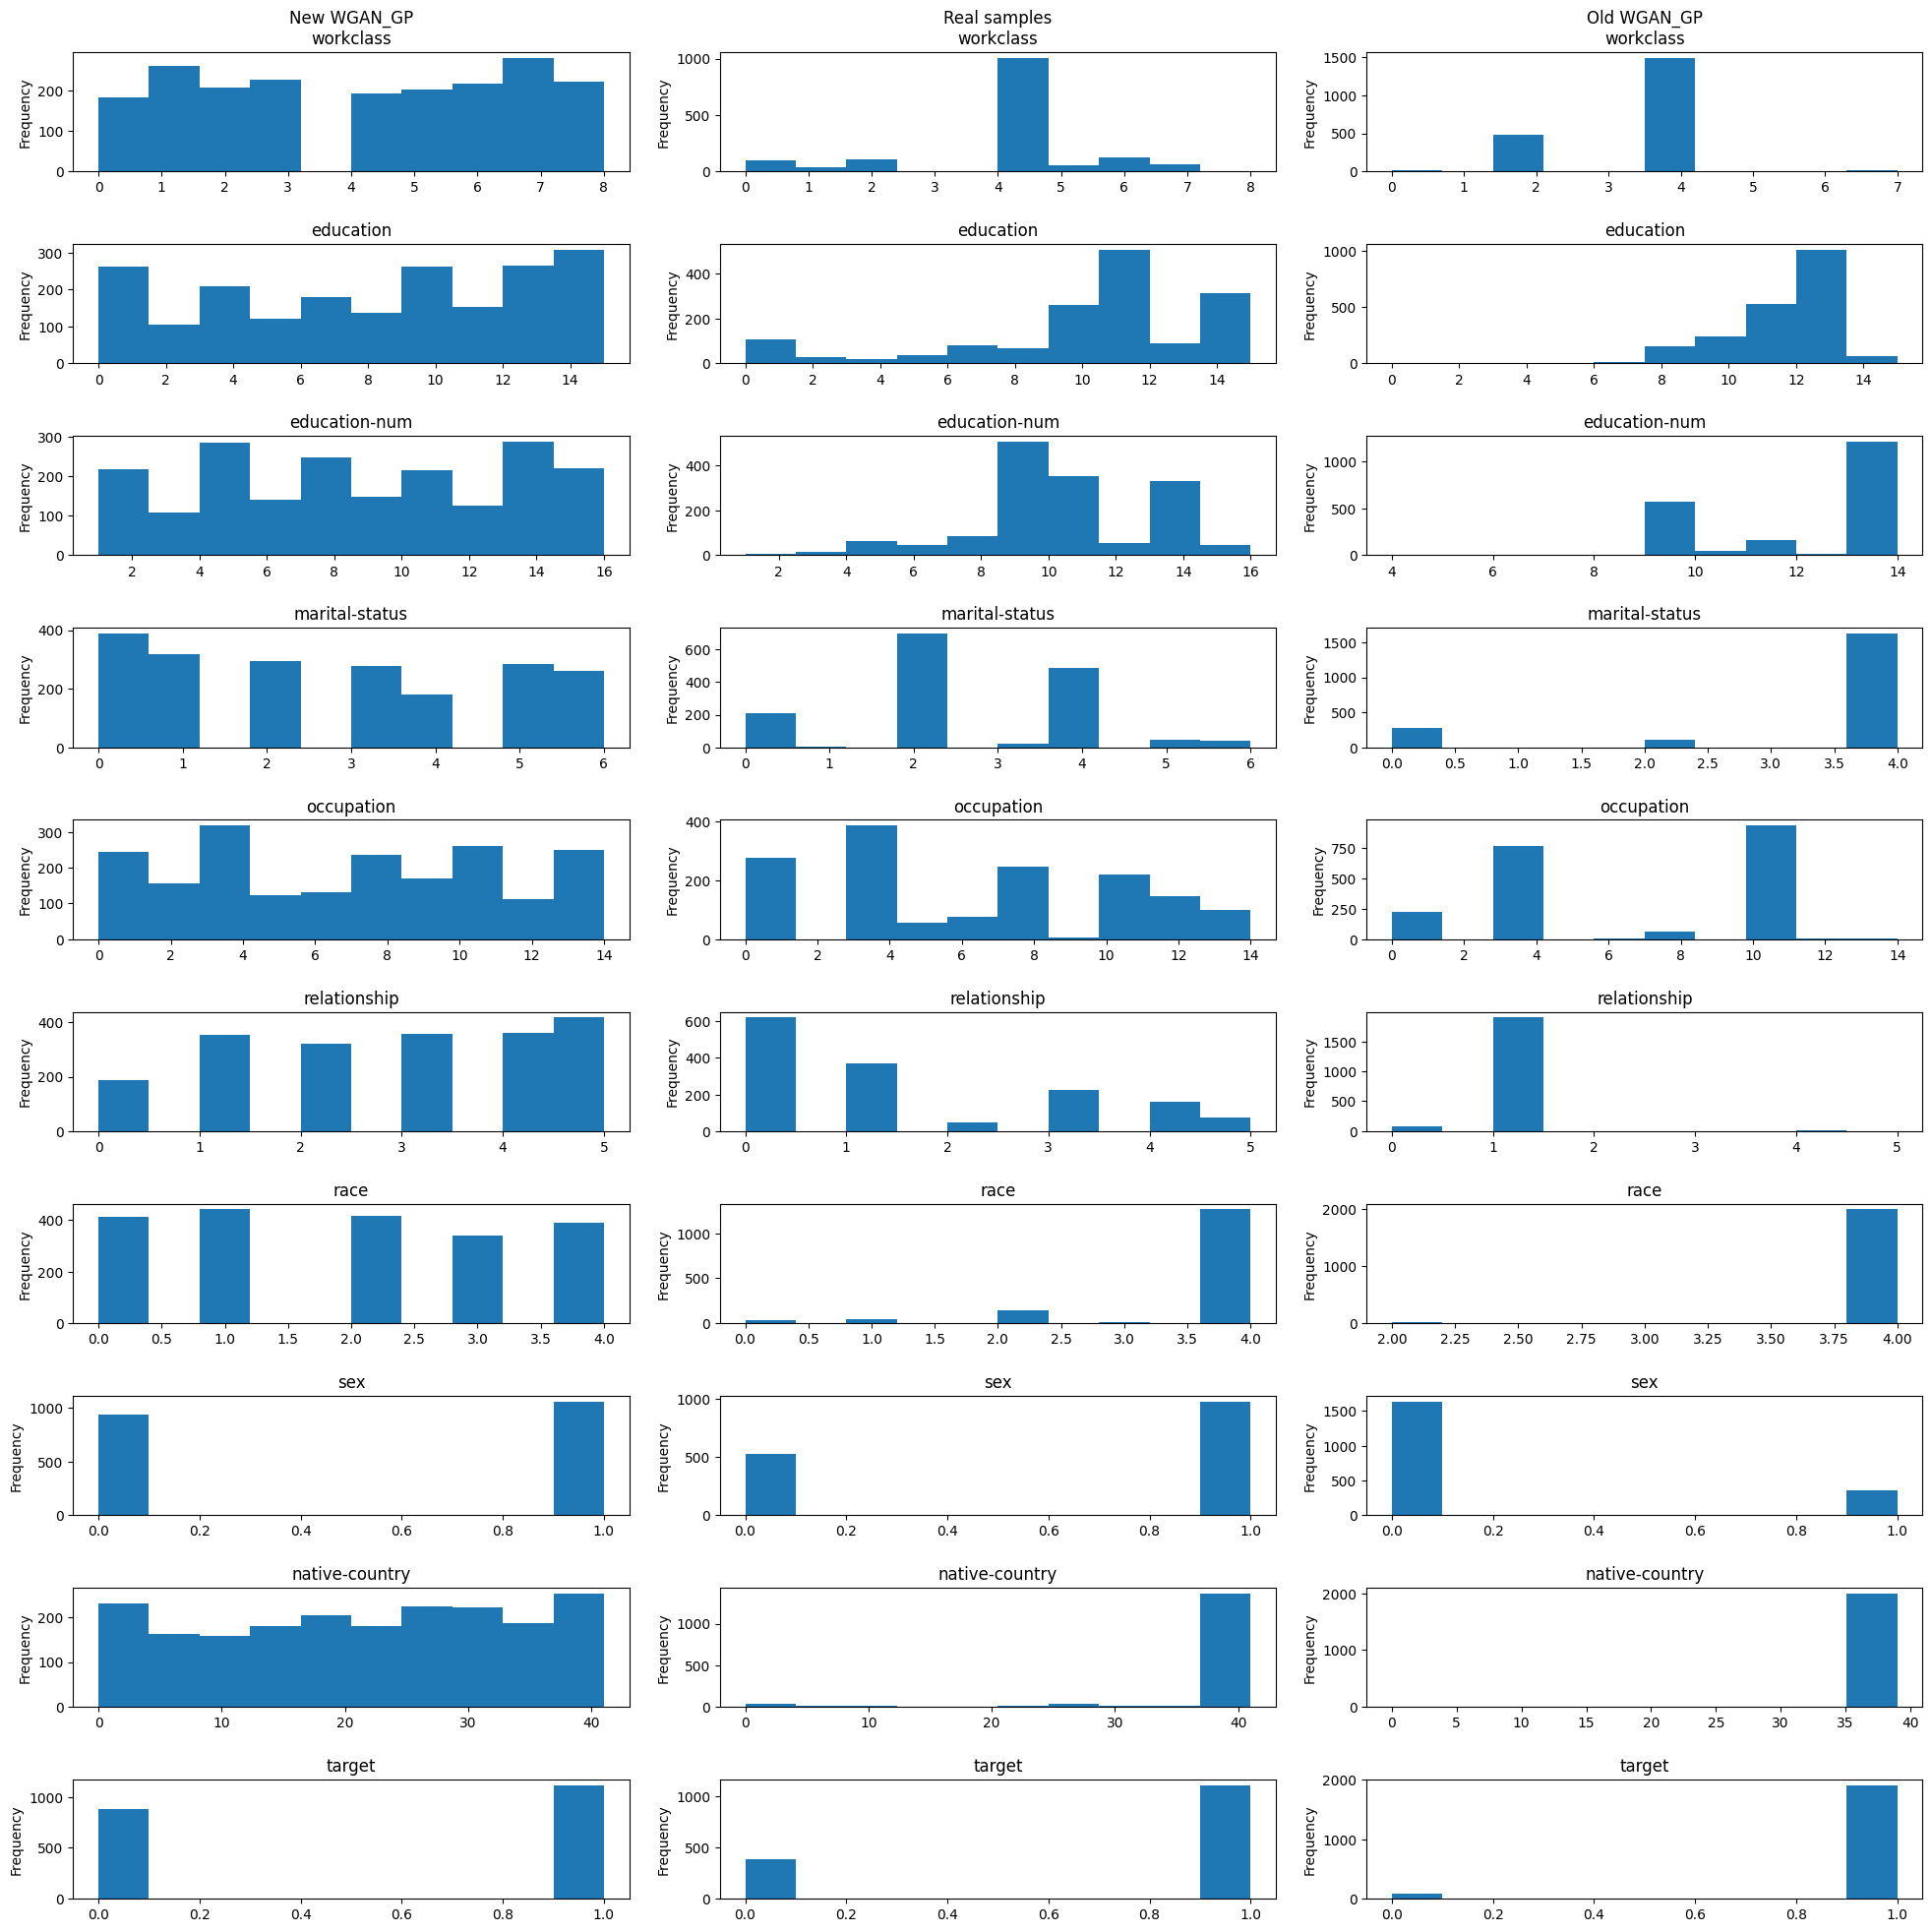

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(cat_cols), ncols=3, figsize= (20,20))
for i, feat in enumerate(cat_cols):
    for j, (name, samples) in enumerate({'New WGAN_GP': new_samples, 'Real samples': real_samples, 'Old WGAN_GP': old_samples}.items()):
        samples[feat].plot(kind='hist', ax=axes[i, j], title=(name +'\n' if i==0 else '') + feat)
fig.tight_layout(pad=2.0)
plt.show()

Did you notice the difference of the Gumbel-Softmax?
By default this feature is implemented in all the regular generators.

Feel free to adapt this notebook to play with different parameters, datasets or even other GANs of the repository.

Also, enjoy the improved categorical generation!